<a href="https://colab.research.google.com/github/shizuo-kaji/TutorialTopologicalDataAnalysis/blob/master/TopologicalDataAnalysisWithPython.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tools for Topological Data Analysis

In this notebook, we will explore:
- The capabilities of TDA for practitioners (Dimensionality reduction, Visualization, Feature extraction, etc.)
- The types of input each method accepts (Point cloud, Image, Time series)
- How different tools can be used in coordination
- Potential new research directions

This notebook is authored by Shizuo Kaji and is maintained [here](https://github.com/shizuo-kaji/TutorialTopologicalDataAnalysis).

## Environment Setup

**English**
This cell checks required packages for both Colab and Jupyter.
Only missing packages are installed, so it is safe to rerun.

Run policy:
- Run `Environment setup` and `Function Definitions` once at the start.
- After that, each section can be executed independently from its `Section Card` and `# Shared setup` cells.

**日本語**
このセルでは Colab と Jupyter の両方で必要なパッケージを確認します。
不足しているものだけをインストールするため、再実行しても安全です。
- 最初に `Environment setup` と `Function Definitions` を 1 回実行します。
- その後は、各セクションの `Section Card` と `# Shared setup` から独立に実行できます。


In [89]:
# Environment setup (Colab/Jupyter).
# Check required packages and update cripser when version is below 0.0.30.
import importlib.metadata
import importlib.util
import re
import subprocess
import sys

REQUIRED_PACKAGES = {
    "ripser": "ripser",
    "umap": "umap-learn",
    "kmapper": "kmapper",
    "cripser": "cripser",
    "gudhi": "gudhi",
    "ipywidgets": "ipywidgets",
    "ot": "pot",
    "tomaster": "tomaster",
    "networkx": "networkx",
    "tqdm": "tqdm",
}

MIN_CRIPSER_VERSION = "0.0.30"

def _version_tuple(version_text: str):
    return tuple(int(part) for part in re.findall(r"\d+", version_text)[:3])

def _is_outdated_cripser(min_version: str):
    try:
        current_version = importlib.metadata.version("cripser")
    except importlib.metadata.PackageNotFoundError:
        return False, None
    return _version_tuple(current_version) < _version_tuple(min_version), current_version

def resolve_package_actions(package_map):
    to_install = []
    to_upgrade = []
    for module_name, pip_name in package_map.items():
        if importlib.util.find_spec(module_name) is None:
            to_install.append(pip_name)
            continue
        if module_name == "cripser":
            outdated, current_version = _is_outdated_cripser(MIN_CRIPSER_VERSION)
            if outdated:
                print(f"Found cripser=={current_version}; upgrading to >= {MIN_CRIPSER_VERSION}.")
                to_upgrade.append(f"{pip_name}>={MIN_CRIPSER_VERSION}")
    return to_install, to_upgrade

missing, to_upgrade = resolve_package_actions(REQUIRED_PACKAGES)
if missing:
    print("Installing missing packages:", ", ".join(missing))
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", *missing])

if to_upgrade:
    print("Upgrading packages:", ", ".join(to_upgrade))
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "--upgrade", *to_upgrade])

if not missing and not to_upgrade:
    print("All core packages are already installed and up to date.")
else:
    print("Environment package check complete.")

IN_COLAB = "google.colab" in sys.modules
print("Python executable:", sys.executable)
print("Python version:", sys.version.split()[0])
print("Running in Colab:", IN_COLAB)


All core packages are already installed and up to date.
Python executable: /opt/homebrew/Caskroom/miniforge/base/bin/python
Python version: 3.12.12
Running in Colab: False


## Function Definitions

**English**
Functions used throughout this notebook are defined in this section.

**日本語**
このセクションでは、ノートブック全体で使用する関数を定義します。

In [249]:
## Load required libraries.
# Standard libraries.
#%matplotlib inline
#%matplotlib widget

import numpy as np
import scipy as sp
import pandas as pd
import glob, os, re
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, clear_output

# Image-related libraries.
from skimage.filters import threshold_otsu
from scipy.ndimage import distance_transform_edt, convolve
import seaborn as sns
sns.set_theme(context="notebook", style="whitegrid", palette="colorblind")
import skimage
from skimage import io
from PIL import Image
# TDA-related libraries.
import cripser
from ripser import ripser
import gudhi

GLOBAL_SEED = 42
np.random.seed(GLOBAL_SEED)

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

import matplotlib as mpl
mpl.rcParams['text.usetex'] = False

print("cripser:",cripser.__version__)
print("GUDHI:",gudhi.__version__)

# Gaussian kernel for convolution.
def gaussian(h, sigma):
  x = np.arange(-h[0], h[0], 1)
  y = np.arange(-h[1], h[1], 1)
  z = np.arange(-h[2], h[2], 1)
  xx, yy, zz = np.meshgrid(x, y, z)
  return np.exp(-(xx**2 + yy**2 + zz**2) / (2 * sigma**2)).astype(np.float32)

# Heat map of cycles with specified birth and death properties.
def heat_map(img, pd, h=3, sigma=1, min_life=10, max_life=255, min_birth=0, max_birth=255, dimension=0, life_weighted=True, location='birth'):
  if len(img.shape) == 2:
    mx, my = img.shape
    mz = 1
    kernel = gaussian([h, h, 1], sigma)
  else:
    mx, my, mz = img.shape
    kernel = gaussian([h, h, h], sigma)

  selected_cycle = np.zeros((mx, my, mz))
  ppd = pd[pd[:, 0] == dimension]
  ppd = ppd[(min_life < ppd[:, 2] - ppd[:, 1]) & (ppd[:, 2] - ppd[:, 1] < max_life)]
  ppd = ppd[(min_birth < ppd[:, 1]) & (ppd[:, 1] < max_birth)]

  for c in ppd:
    x, y, z = (int(c[3]), int(c[4]), int(c[5])) if location == 'birth' else (int(c[6]), int(c[7]), int(c[8]))
    w = c[2] - c[1] if life_weighted else 1
    selected_cycle[x, y, z] += w

  cycle_conv = convolve(selected_cycle, kernel)
  return np.squeeze(cycle_conv)

# Slice viewer for a 3D image.
def explore_slices(data, cmap="gray"):
  from ipywidgets import interact
  N = data.shape[-1]

  @interact(plane=(0, N - 1))
  def display_slice(plane=N // 2):
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.imshow(data[:, :, plane], cmap=cmap)
    plt.show()

  return display_slice

# Apply binary thresholding and a distance transform to an image.
def dt(img, radius=None, signed=False):
  if radius is not None:
    from skimage.filters import rank
    from skimage.morphology import disk
    bw_img = img >= rank.otsu(img, disk(radius))
  else:
    bw_img = img >= threshold_otsu(img)

  dt_img = distance_transform_edt(bw_img)
  if signed:
    dt_img -= distance_transform_edt(~bw_img)

  return dt_img

# Convert GUDHI's diagram format to Ripser style.
def gudhi2ripser(diag):
  max_dim = max([p[0] for p in diag])
  return [np.array([p[1:][0] for p in diag if p[0] == i]) for i in range(max_dim+1)]

# Convert a list of objects with `.diagram` tensors to Ripser-style arrays.
def torch2ripser(diagrams):
  return [diagrams[i].diagram.cpu().detach().numpy() for i in range(len(diagrams))]


cripser: 0.0.31
GUDHI: 3.11.0


# Feature Extraction from Different Data Types

Persistent Homology (PH) converts a wide range of data types into topological feature representations.
These representations can then be used for analysis and machine-learning workflows.

**日本語**
Persistent Homology (PH) は、さまざまなデータ型を位相的な特徴表現へ変換します。
この特徴表現は、解析や機械学習のワークフローで利用できます。

## Point cloud

### Section Card

**English**
- Objective: Extract and compare topological signatures (connected components and loops) from point-cloud data.
- Input: 2D/3D point clouds or pairwise distance matrices.
- Output: Persistence diagrams, distance between persistence diagrams

**日本語**
- 目的: 点群データから位相的特徴（連結成分とループ）を抽出し、比較します。
- 入力: 2D/3D 点群または距離行列。
- 出力: パーシステンス図、パーシステンス図の間の距離


In [36]:
# Shared setup
# Common imports, constants, and helper utilities for this section.
POINT_CLOUD_SEED = 42
np.random.seed(POINT_CLOUD_SEED)

from scipy.spatial import distance_matrix
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.ndimage import distance_transform_edt
from sklearn.manifold import MDS
from ipywidgets import interact, FloatSlider
from gudhi.dtm_rips_complex import DTMRipsComplex
import gudhi.hera
import gudhi.wasserstein
import networkx as nx
import matplotlib.colors as colors
import matplotlib.cm as cm

In [37]:
# Sample points on a sphere and in a cube.
def sample_sphere(n, dim=3, radius=1,sigma=0.5):
    X = np.random.rand(n, dim) - 0.5
    X = X / np.sqrt(np.sum(X**2, axis=1, keepdims=True))
    X *= radius
    X += np.random.normal(scale=sigma, size=(len(X), dim))
    #X += np.random.uniform(-1, 1, 3)
    return X

def sample_cube(n, dim=3, radius=1,sigma=0.5):
    X = 2 * np.random.rand(n, dim) - 1
    X *= radius
    X += np.random.normal(scale=sigma, size=(len(X), dim))
    #X += np.random.uniform(-1, 1, 3)
    return X

### first example

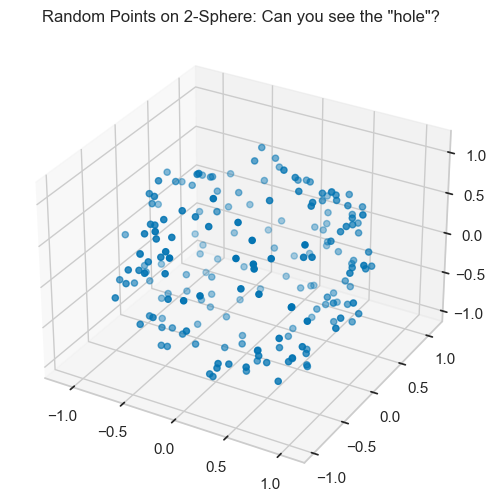

In [38]:
## Generate random data on the 2-sphere.
X = sample_sphere(200, dim=3, radius=1, sigma=0.1)

# Plot points on the 2-sphere.
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c='b', marker='o')
ax.set_title('Random Points on 2-Sphere: Can you see the "hole"?')
plt.show()

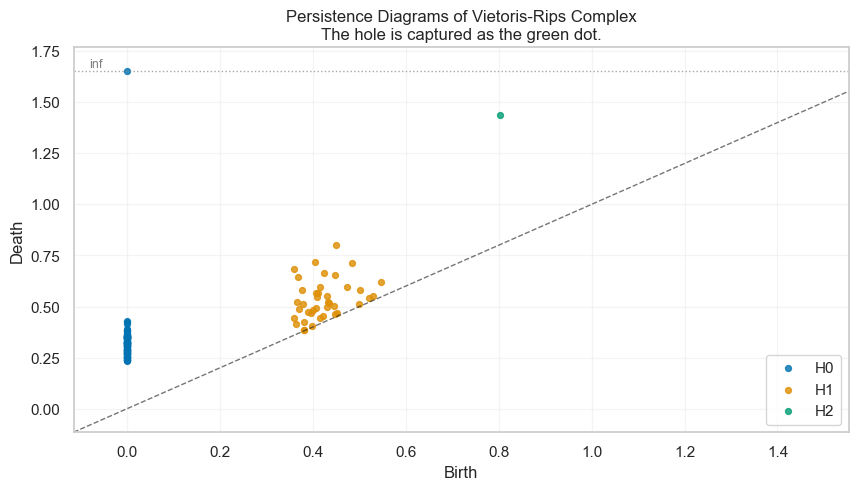

In [39]:
## Compute persistent homology (PH) of the Vietoris-Rips (VR) complex and plot the persistence diagram (PD).
## The VR complex has a very large number of simplices, so tractable input sizes are typically on the order of 1,000 points.
## To reduce computational cost, you can compute an approximate PH by setting, for example, `n_perm=100` (subsampling 100 well-separated points).
diag = ripser(X, maxdim=2, n_perm=100)['dgms']

# Plot persistence diagrams.
fig, ax = plt.subplots(figsize=(10, 5))
cripser.plot_diagrams(diag, ax=ax)
ax.set_title('Persistence Diagrams of Vietoris-Rips Complex\nThe hole is captured as the green dot.')
plt.show()

#### Vectorisation of persistence diagram

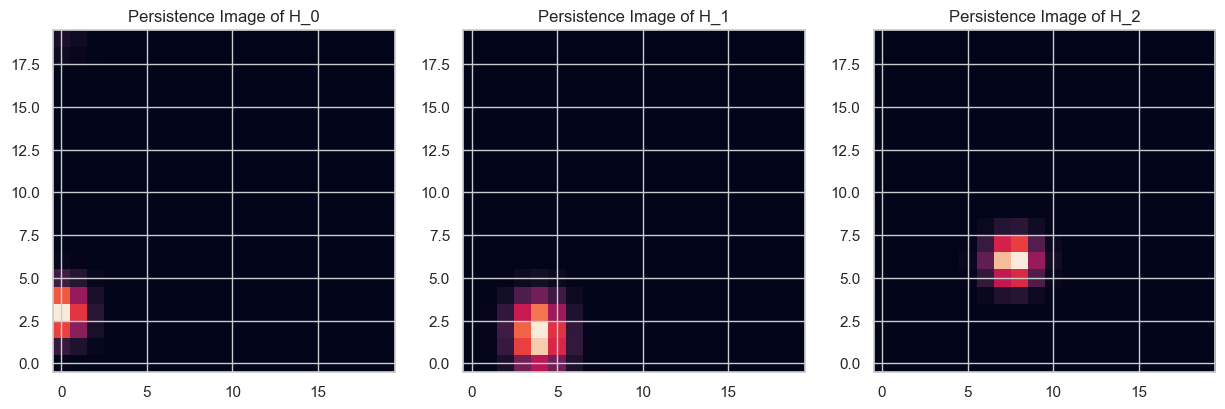

In [40]:
# A persistence image converts the persistence diagram into a fixed-length vector.
# This is convenient for downstream tasks using standard machine-learning techniques.
# The downside is that you need to choose hyperparameters.

min_birth, max_death = 0, 2
dclip = [np.clip(d, min_birth, max_death) for d in diag]
bin_size = 0.1
n_bins = int((max_death - min_birth) / bin_size)

pimgs = []
for d in dclip:
    ph = np.column_stack([np.zeros((len(d), 1)), d])
    pim = cripser.persistence_image(
        ph,
        homology_dims=[0],
        n_birth_bins=n_bins,
        n_life_bins=n_bins,
        birth_range=(min_birth, max_death),
        life_range=(0, max_death - min_birth),
        sigma=0.1,
    )[0]
    pimgs.append(pim)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    axs[i].imshow(pimgs[i], origin="lower")
    axs[i].set_title("Persistence Image of H_{}".format(i))
plt.show()

#### different types of complexes

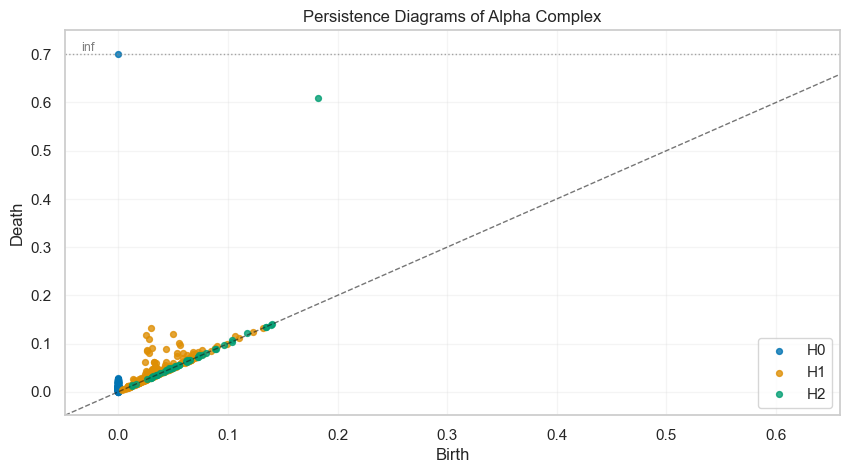

In [41]:
## From a point cloud, we can construct different complexes.
# The choice affects both performance and outcomes, so it requires careful consideration.
# Let us look at an example of an alpha complex.

simplex_tree = gudhi.AlphaComplex(points=X).create_simplex_tree()
diag = simplex_tree.persistence()

## We observe a notable difference in H_1 compared with the VR-complex result above.
#gudhi.plot_persistence_diagram(diag, legend=True)
di = gudhi2ripser(diag)
fig, ax = plt.subplots(figsize=(10, 5))
cripser.plot_diagrams(di, ax=ax)
ax.set_title('Persistence Diagrams of Alpha Complex')
plt.show()

### 2D point cloud with three clusters

In [42]:
# Compute the Vietoris-Rips complex (edges, triangles, tetrahedra) for a given epsilon (inefficiently).
def vietoris_rips_complex(points, epsilon):
    dist_matrix = distance_matrix(points, points)
    num_points = len(points)

    # 1-simplices (edges).
    edges = [(i, j) for i in range(num_points) for j in range(i+1, num_points) if dist_matrix[i, j] <= epsilon]

    # 2-simplices (triangles).
    triangles = [
        (i, j, k)
        for i in range(num_points)
        for j in range(i+1, num_points)
        for k in range(j+1, num_points)
        if dist_matrix[i, j] <= epsilon and dist_matrix[i, k] <= epsilon and dist_matrix[j, k] <= epsilon
    ]

    # 3-simplices (tetrahedra).
    tetrahedra = [
        (i, j, k, l)
        for i in range(num_points)
        for j in range(i+1, num_points)
        for k in range(j+1, num_points)
        for l in range(k+1, num_points)
        if (
            dist_matrix[i, j] <= epsilon and dist_matrix[i, k] <= epsilon and dist_matrix[i, l] <= epsilon and
            dist_matrix[j, k] <= epsilon and dist_matrix[j, l] <= epsilon and dist_matrix[k, l] <= epsilon
        )
    ]

    return edges, triangles, tetrahedra

# Plot the point cloud and the Vietoris-Rips complex.
def plot_vietoris_rips(points, epsilon):
    edges, triangles, tetrahedra = vietoris_rips_complex(points, epsilon)

    # Compute the distance-transform image.
    distance_transform = compute_distance_transform(points)

    plt.figure(figsize=(8, 8))

    # Plot the distance-transform image.
    plt.imshow(distance_transform, origin="lower", cmap="viridis", extent=[0, 1, 0, 1], alpha=0.6)

    # Plot points.
    for point in points:
        plt.scatter(*point, color='blue', s=50)

    # Plot edges.
    for i, j in edges:
        plt.plot(
            [points[i][0], points[j][0]],
            [points[i][1], points[j][1]],
            color='gray',
            linestyle='--',
            linewidth=1
        )

    # Plot triangles.
    for i, j, k in triangles:
        plt.fill(
            [points[i][0], points[j][0], points[k][0]],
            [points[i][1], points[j][1], points[k][1]],
            color='lightblue',
            alpha=0.5
        )

    # Plot tetrahedra.
    for i, j, k, l in tetrahedra:
        x_coords = [points[i][0], points[j][0], points[k][0], points[l][0]]
        y_coords = [points[i][1], points[j][1], points[k][1], points[l][1]]
        plt.fill(x_coords, y_coords, color='lightgreen', alpha=0.3)

    plt.title(f"Vietoris-Rips Complex (epsilon = {epsilon})")
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

# Compute the distance-transform image.
def compute_distance_transform(points, grid_size=100):
    grid = np.zeros((grid_size, grid_size))
    for x, y in points:
        grid[int(y * (grid_size - 1)), int(x * (grid_size - 1))] = 1
    distance_transform = distance_transform_edt(1 - grid)
    return distance_transform


# Interactive widget for Vietoris-Rips complex visualisation.
def interactive_vietoris_rips(points=None, num_pts = 10, e_min=0.0, e_max=1.0):
    if points is None:
      points = sample_sphere(num_pts, dim=2, radius=0.3,sigma=0)+0.5

    interact(
        lambda epsilon: plot_vietoris_rips(points, epsilon),
        epsilon=FloatSlider(value=0.0, min=e_min, max=e_max, step=(e_max-e_min)/20, description='epsilon')
    )

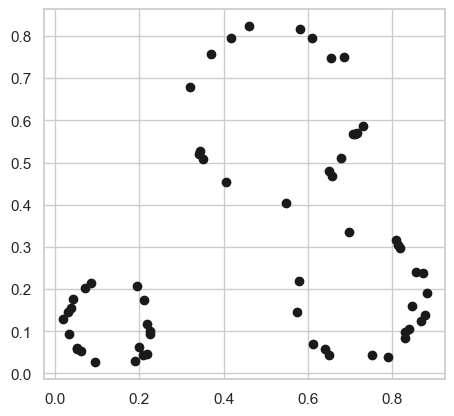

In [12]:
# Three circles: three clusters (connected components), each with non-trivial topology (a loop).
sigma=0.1
pts0 = sample_sphere(20, dim=2, radius=1, sigma=sigma)
pts1 = sample_sphere(20, dim=2, radius=2, sigma=sigma)+np.array([4,5])
pts2 = sample_sphere(20, dim=2, radius=1.5, sigma=sigma)+np.array([6,0.7])
pts = 0.1*(np.vstack([pts0,pts1,pts2])+np.array([1.2,1.2]))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_aspect('equal')
plt.scatter(pts[:,0], pts[:,1],c="k")
#plt.axis("off")
plt.show()

In [ ]:
interactive_vietoris_rips(pts, e_min=0.0, e_max=0.5)

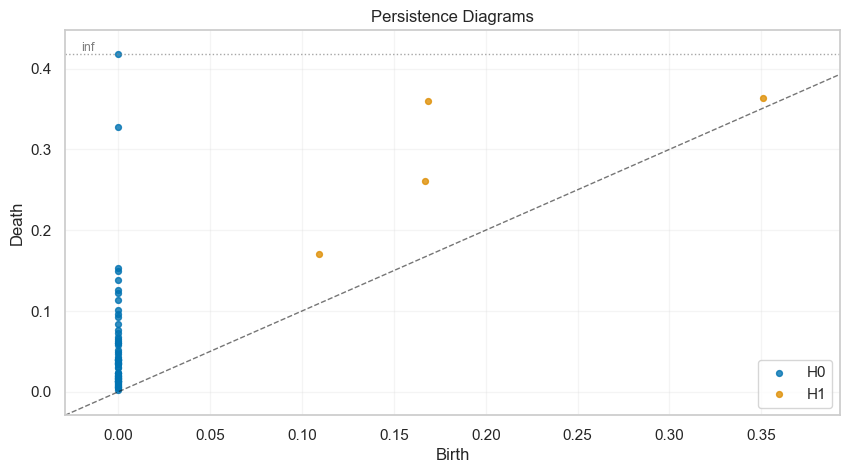

In [43]:
# Three prominent H_0 classes correspond to the three clusters.
# Three prominent H_1 classes correspond to the three circles.

rips = gudhi.RipsComplex(points=pts)
rips = DTMRipsComplex(points=pts) # Distance-To-Measure VR-complex is more robust against noise
st_rips = rips.create_simplex_tree(2)
diag = st_rips.persistence()
di = gudhi2ripser(diag)
fig, ax = plt.subplots(figsize=(10, 5))
cripser.plot_diagrams(di, ax=ax)
ax.set_title('Persistence Diagrams')
plt.show()

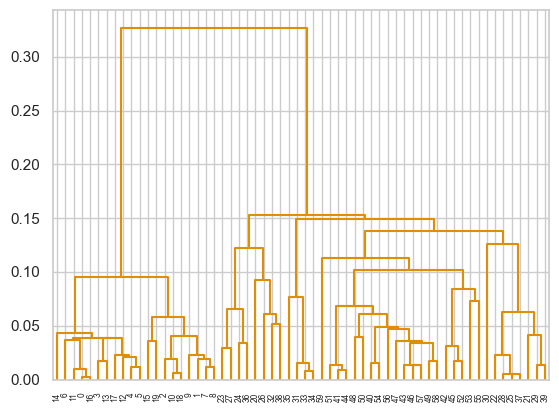

In [44]:
# PH_0 corresponds to hierarchical clustering.
Z = linkage(pts, 'single')
dn = dendrogram(Z,color_threshold=1.1)
plt.show()

### Distance between persistent diagrams

Persistent diagrams live in a metric space.
So we can measure similarity between two samples.

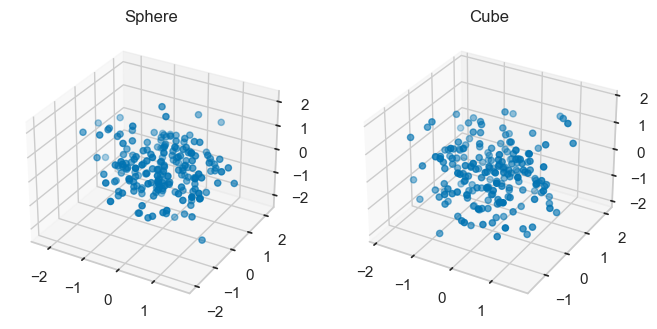

In [45]:
## Generate point clouds from a sphere and a cube, then compute pairwise bottleneck distances between their PH descriptors.
n = 5   # number of spheres (cubes). In total, we'll have 2n sets of point clouds.
spheres = [sample_sphere(200) for _ in range(n)]
cubes = [sample_cube(200) for _ in range(n)]
X = spheres + cubes
Y = [0] * n + [1] * n

## Plot the point clouds: visually, it is not easy to distinguish 3D point clouds.
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(spheres[0][:, 0], spheres[0][:, 1], spheres[0][:, 2])
ax.set_title('Sphere')
ax = fig.add_subplot(122, projection='3d')
ax.scatter(cubes[0][:, 0], cubes[0][:, 1], cubes[0][:, 2])
ax.set_title('Cube')
plt.show()

# Compute PH and pairwise distances.
pd = [ripser(point_cloud, maxdim=2, n_perm=100)['dgms'][2] for point_cloud in X]

D = np.zeros((2 * n, 2 * n))
for i in range(2 * n - 1):
    for j in range(i + 1, 2 * n):
        D[i, j] = gudhi.bottleneck_distance(pd[i], pd[j])

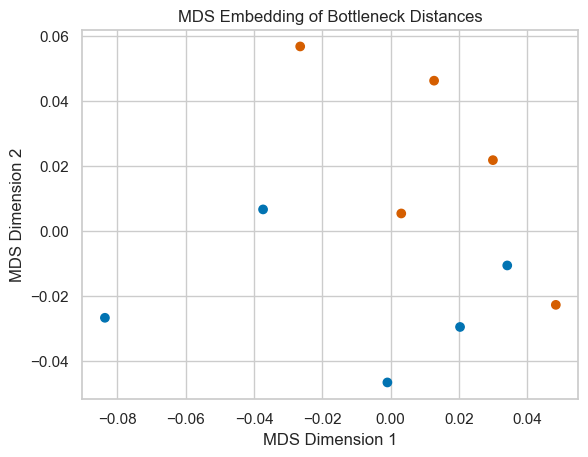

In [46]:
## Bottleneck distance distinguishes spheres from cubes.
# We obtain a distance matrix over point clouds, yielding a finite metric space with 2n points.
# For visualisation, we use multidimensional scaling, which embeds a finite metric space into Euclidean space.
# Blue points represent cubes, and red points represent spheres.

# Ensure the distance matrix is symmetric.
D_symmetric = D + D.T

# Apply MDS.
mds = MDS(n_components=2, dissimilarity='precomputed', n_init=4)
X_mds = mds.fit_transform(D_symmetric)

# Plot the results.
col = ['r', 'b']
plt.scatter(X_mds[:, 0], X_mds[:, 1], c=[col[y] for y in Y])
plt.title('MDS Embedding of Bottleneck Distances')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.show()

#### Remark on Bottleneck and p-Wasserstein distances

Distances
Bottleneck (GUDHI) with L-infty metric: 6.499999999999999
2-Wasserstein (GUDHI-hera) with L-infty metric: 12.504999999999999
2-Wasserstein (GUDHI-hera) with L2 Euclidean metric: 17.684740597475553
99-Wasserstein (GUDHI-hera) with L2 Euclidean metric: 9.192421749823405
99-Wasserstein (GUDHI-hera) with L-infty metric (approx. Bottleneck distance): 6.500023754826838


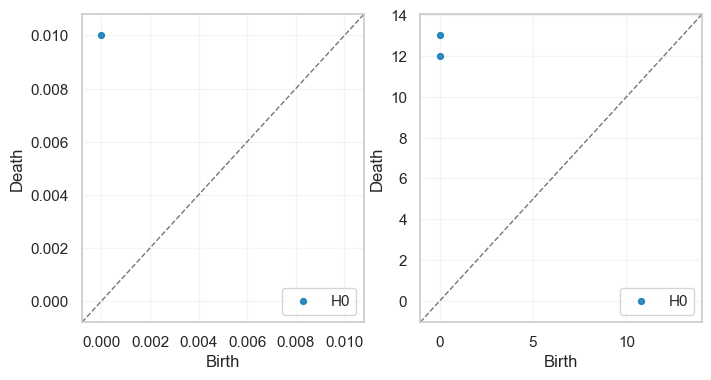

In [47]:
# Wasserstein distance has two parameters: exponent `p` and the ground-space metric.

# One point in a plane.
X,Y =np.array([[0., 0.01]]), np.array([[0., 13.],[0.,12.]])
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(121)
cripser.plot_diagrams(X, ax=ax)
ax = fig.add_subplot(122)
cripser.plot_diagrams(Y, ax=ax)

print("Distances")
print("Bottleneck (GUDHI) with L-infty metric:", gudhi.bottleneck_distance(X,Y))
#print(gudhi.wasserstein.wasserstein_distance(X, Y, order=1, internal_p=2))  # Requires POT.
print("2-Wasserstein (GUDHI-hera) with L-infty metric:", gudhi.hera.wasserstein_distance(X, Y, order=1, internal_p=np.inf))
print("2-Wasserstein (GUDHI-hera) with L2 Euclidean metric:", gudhi.hera.wasserstein_distance(X, Y, order=1, internal_p=2))
print("99-Wasserstein (GUDHI-hera) with L2 Euclidean metric:", gudhi.hera.wasserstein_distance(X, Y, order=99, internal_p=2))
print("99-Wasserstein (GUDHI-hera) with L-infty metric (approx. Bottleneck distance):", gudhi.hera.wasserstein_distance(X, Y, order=99, internal_p=np.inf))

### point cloud in an ambient metric space (graph)

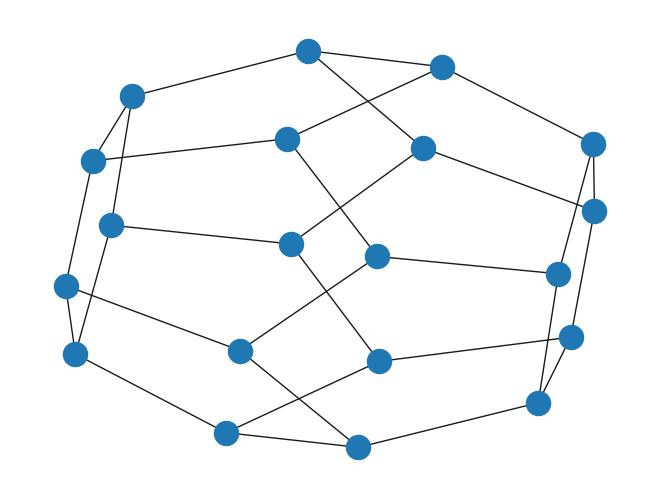

In [48]:
## A VR complex can also be constructed from an abstract distance matrix, not only from a point cloud in Euclidean space.
# Here is an example based on graph distance.
G = nx.dodecahedral_graph()
nx.draw(G)
D = np.array(nx.floyd_warshall_numpy(G))  # distance matrix
plt.show()

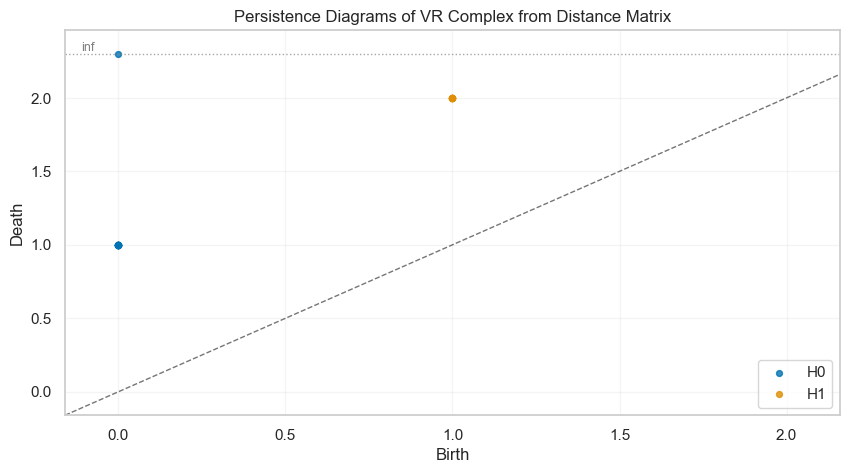

In [49]:
# Compute persistent homology of the distance matrix.
diag = ripser(D, distance_matrix=True)['dgms']

# Plot persistence diagrams.
fig, ax = plt.subplots(figsize=(10, 5))
cripser.plot_diagrams(diag, ax=ax)
ax.set_title('Persistence Diagrams of VR Complex from Distance Matrix')
plt.show()

### A direction for new research

An interesting question is: for a set of point clouds (or images), we can first compute PD for each point cloud and then compute the distance matrix of PDs. PH of the distance matrix defines a feature for "a set of point clouds". Do we have a practical application?

For example, we have multiple measurements for objects from each class, and each measurement yields PH. In this case, "PH of PD" provides a collective feature for the objects belonging to the class.


### Trajectory of cycles in a sequence of PD

In [50]:
# Sample from Figure 8.
def create_figure8(num_samples=200):
  t = np.linspace(0, 2*np.pi, num=num_samples)
  X = np.stack((np.sqrt(2)*np.cos(t) / (np.sin(t)**2+1), np.sqrt(2)*np.cos(t)*np.sin(t) / (np.sin(t)**2+1))).T
  X += 0.1*np.random.random(X.shape)
  return(X)

IndexError: index 7 is out of bounds for axis 1 with size 7

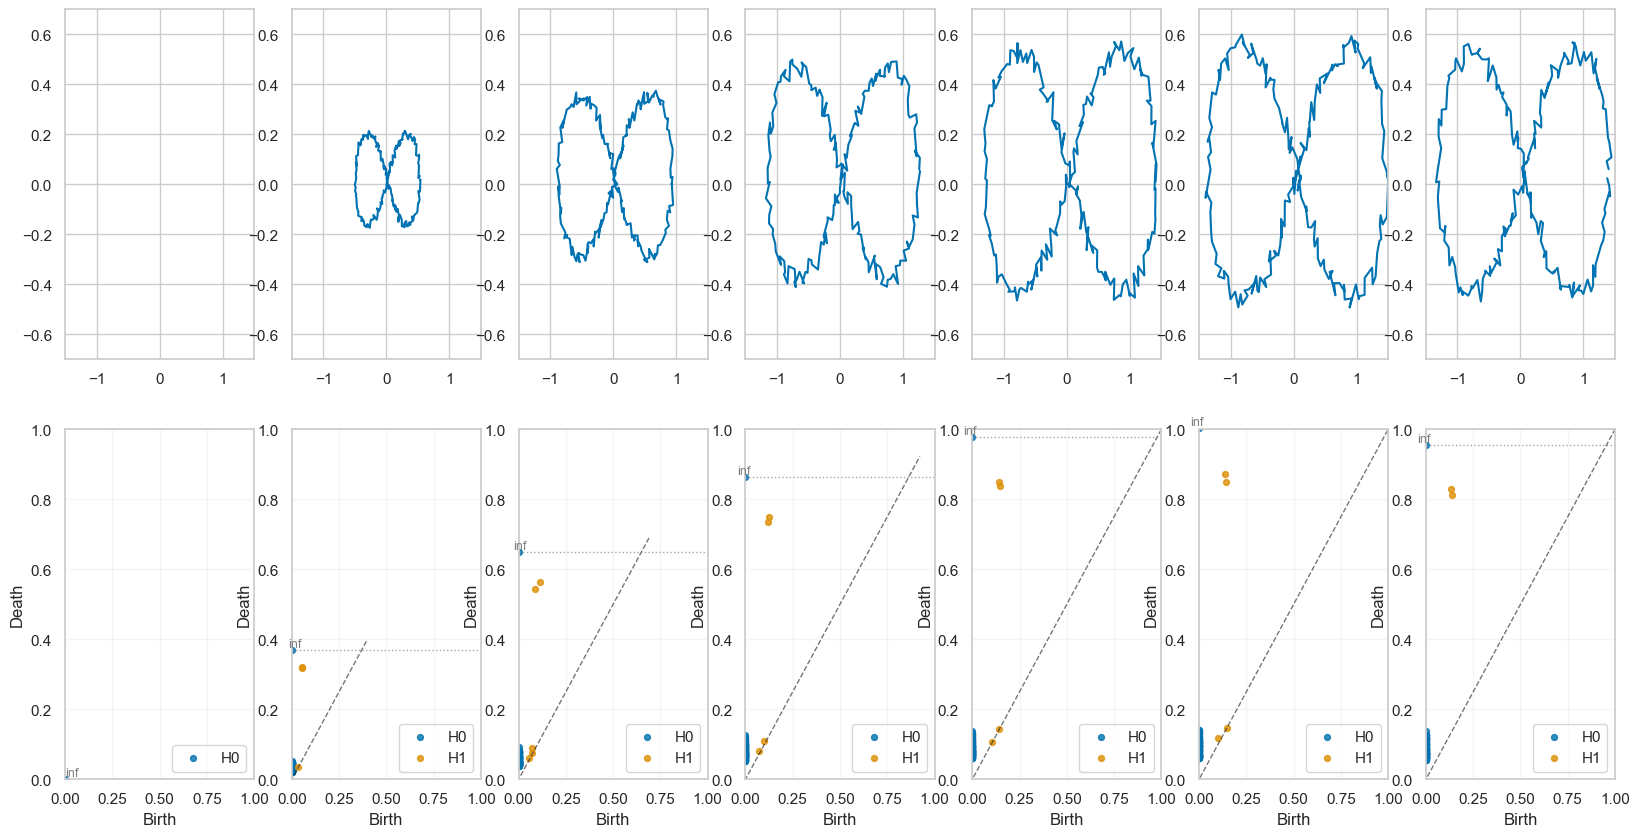

In [ ]:
# Create a sequence of figure-eight shapes with varying scale and compute their PDs.
Xs = []
diags = []
frames = 30
a = frames / 2

for fr in range(frames):
  scale = (a**2 - (fr - a)**2) / (a**2)
  X = create_figure8() * scale
  Xs.append(X)
  diags.append(ripser(X, maxdim=1, n_perm=100)['dgms'])

# Plot a subset of the samples.
num_disp = 7
fig, axs = plt.subplots(2, num_disp, figsize=(20, 10))

step = frames // (num_disp + 1)
if step == 0:
    step = 1 # Avoid division by zero or empty slices if frames is very small

# Iterate up to num_disp times, taking samples at 'step' intervals
for i in range(num_disp):
    # Get the index for Xs and diags
    data_idx = i * step
    if data_idx >= len(Xs):
        break

    x = Xs[data_idx]
    dg = diags[data_idx]

    axs[0, i].set_xlim(-1.5, 1.5)
    axs[0, i].set_ylim(-0.7, 0.7)
    axs[0, i].plot(*x.T)
    cripser.plot_diagrams(dg, ax=axs[1, i])
    axs[1, i].set_xlim(0, 1)
    axs[1, i].set_ylim(0, 1)

plt.show()

In [52]:
# Match cycles between adjacent frames and plot their trajectories.

def cycle_trajectory(diags, dim):
  fig, ax = plt.subplots()
  plt.xlim(0, 0.3)
  plt.ylim(0, 1)
  usercmap = plt.get_cmap('jet')
  cNorm = colors.Normalize(vmin=0, vmax=len(diags))
  scalarMap = cm.ScalarMappable(norm=cNorm, cmap=usercmap)

  for i in range(len(diags) - 1):
    D1 = diags[i][dim]
    D2 = diags[i + 1][dim]
    d, M = gudhi.wasserstein.wasserstein_distance(D1, D2, matching=True, order=1, internal_p=2)
    for m in M:
      m0 = int(m[0])  # matched ids
      m1 = int(m[1])
      if -1 < m0 < len(D1) and -1 < m1 < len(D2):
        plt.plot([D1[m0][0], D2[m1][0]], [D1[m0][1], D2[m1][1]], 'k-', lw=1)
        plt.plot(*D2[m1], 'o', color=scalarMap.to_rgba(i))

  cax = fig.add_axes([0.92, 0.1, 0.03, 0.8])
  plt.colorbar(scalarMap, cax=cax, label="time")
  plt.xlabel("birth")
  plt.ylabel("life")
  plt.show()

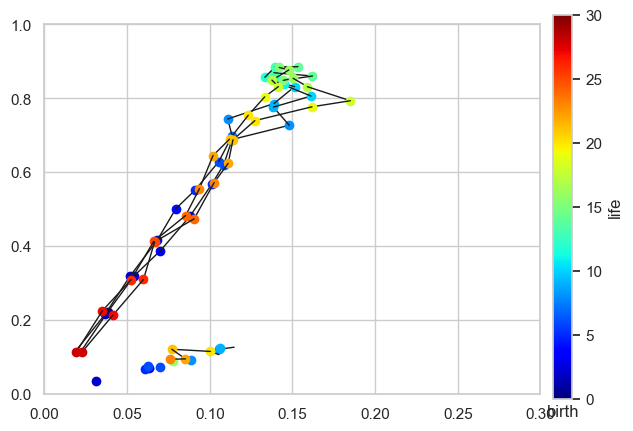

In [29]:
## Visualise the H_1 trajectory.
# Blue: early frames; red: late frames.
# We observe two cycles emerging, growing (longer lifetimes), then returning and eventually disappearing.
# Points with short lifetimes are likely noise.
cycle_trajectory(diags,dim=1)

## Image

A greyscale image is a function on the plane.

The cubical complex is constructed to compute PH.

### Section Card

**English**
- Objective: Treat images as cubical complexes and extract topological features.
- Binary and greyscale images, distance-transform, Persistence diagrams, and classification example

**日本語**
- 目的: 画像を cubical complex として扱い、形状に基づく位相特徴を抽出します。
- 二値画像とグレースケール画像，距離変換，パーシステンス図、分類問題のデモ


In [53]:
# Shared setup
# Common imports, constants, and helper utilities for this section.
IMAGE_SEED = 42
np.random.seed(IMAGE_SEED)

from ipywidgets import interact, FloatSlider
from skimage import data
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

### Cubical complex

[dim,birth,death,x1,y1,z1,x2,y2,z2]: V-construction
[[0 0 1 3 0 0 3 1 0]
 [0 0 9 3 4 0 0 0 0]
 [1 1 2 1 2 0 1 3 0]]
[dim,birth,death,x1,y1,z1,x2,y2,z2]: T-construction
[[0 0 1 3 0 0 3 1 0]
 [0 0 9 3 4 0 0 0 0]
 [1 1 2 1 2 0 1 3 0]]


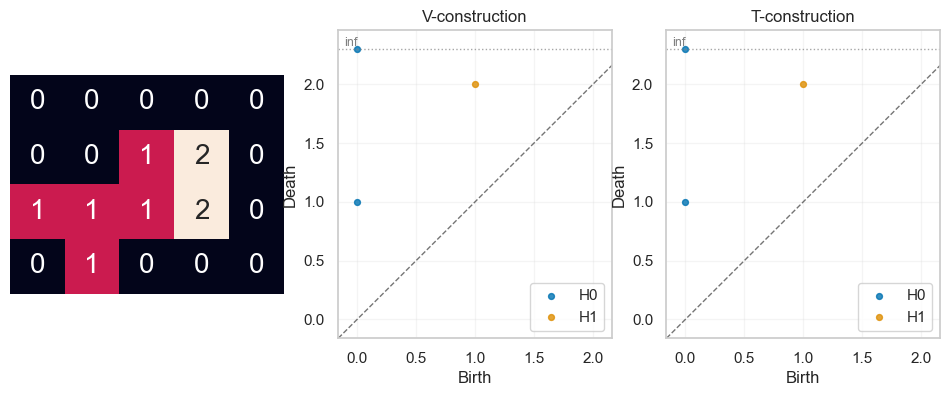

In [54]:
## Simple example.

# Define a 2D array.
simple_img=np.array([[0,0,0,0,0],
                      [0,0,1,2,0],
                      [1,1,1,2,0],
                      [0,1,0,0,0]])

# Plot the array.
fig,axs = plt.subplots(1,3,figsize=(12,4))
sns.heatmap(simple_img, annot=True, square=True, yticklabels=False, xticklabels=False, annot_kws={"fontsize":20}, cbar=False, ax=axs[0])

# Compute PH of the 2D array: there are two main ways to construct a cubical complex from the array.
# In this example, we do not see a clear difference in the persistence diagram.
pd = cripser.compute_ph(simple_img) # V-construction
pdt = cripser.compute_ph(simple_img, filtration="T") # T-construction

# Each row has the form (dim, birth, death, x1, y1, z1, x2, y2, z2), where (x1, y1, z1) is the creator-cell location and (x2, y2, z2) is the destroyer-cell location.
print("[dim,birth,death,x1,y1,z1,x2,y2,z2]: V-construction")
print(np.where(pd<9, pd, 9).astype(int)) # replace infty with 9 for printing
print("[dim,birth,death,x1,y1,z1,x2,y2,z2]: T-construction")
print(np.where(pdt<9, pdt, 9).astype(int)) # replace infty with 9 for printing

# Plot persistence diagram.
cripser.plot_diagrams(pd, ax=axs[1], title='V-construction')
cripser.plot_diagrams(pdt, ax=axs[2], title='T-construction')
plt.show()

In [ ]:
# Visualise the V-construction.

# Compute a cubical complex for a greyscale image.
def cubical_complex(image, threshold):
    # Binary thresholding.
    binary_image = (image <= threshold).astype(int)

    # Find active cells (pixels that meet the threshold).
    active_cells = np.argwhere(binary_image == 1)

    # Cubes (vertices, edges, squares).
    vertices = [(x, y) for x, y in active_cells]

    edges = []
    for x, y in active_cells:
        # Check the right neighbour.
        if x + 1 < image.shape[0] and binary_image[x + 1, y] == 1:
            edges.append(((x, y), (x + 1, y)))
        # Check the lower neighbour.
        if y + 1 < image.shape[1] and binary_image[x, y + 1] == 1:
            edges.append(((x, y), (x, y + 1)))

    squares = []
    for x, y in active_cells:
        if (x + 1 < image.shape[0] and y + 1 < image.shape[1] and
            binary_image[x + 1, y] == 1 and binary_image[x, y + 1] == 1 and binary_image[x + 1, y + 1] == 1):
            squares.append(((x, y), (x + 1, y), (x, y + 1), (x + 1, y + 1)))

    return vertices, edges, squares

# Plot the cubical complex.
def plot_cubical_complex(image, threshold):
    vertices, edges, squares = cubical_complex(image, threshold)

    plt.figure(figsize=(8, 8))

    # Plot the image.
    plt.imshow(image, cmap="gray", origin="lower", extent=[0, image.shape[1], 0, image.shape[0]])

    # Annotate pixel values.
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            plt.text(y + 0.5, x + 0.5, f"{image[x, y]:.2f}", color="red",
                     ha="center", va="center", fontsize=8, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white", alpha=0.7))

    # Plot vertices.
    for x, y in vertices:
        plt.scatter(y + 0.5, x + 0.5, color="blue", s=300)

    # Plot edges.
    for (x1, y1), (x2, y2) in edges:
        plt.plot([y1 + 0.5, y2 + 0.5], [x1 + 0.5, x2 + 0.5], color="red", linewidth=2)

    # Plot squares.
    for (x1, y1), (x2, y2), (x3, y3), (x4, y4) in squares:
        plt.fill(
            [y1 + 0.5, y2 + 0.5, y4 + 0.5, y3 + 0.5],
            [x1 + 0.5, x2 + 0.5, x4 + 0.5, x3 + 0.5],
            color="green",
            alpha=0.3,
        )

    plt.title(f"Cubical Complex (threshold = {threshold})")
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

# Interactive widget for cubical-complex visualisation.
def interactive_cubical_complex(image=None):
    if image is None:
      size = 5
      image = np.random.rand(size, size)
    interact(
        lambda threshold: plot_cubical_complex(image, threshold),
        threshold=FloatSlider(value=0.0, min=0, max=image.max(), step=image.max()/10, description='Threshold')
    )

interactive_cubical_complex(simple_img)

[dim,birth,death,x1,y1,z1,x2,y2,z2]: V-construction
[[0 0 1 3 0 0 3 1 0]
 [0 0 9 3 4 0 0 0 0]
 [1 1 2 2 2 0 1 3 0]]
[dim,birth,death,x1,y1,z1,x2,y2,z2]: T-construction
[[0 0 9 3 4 0 0 0 0]
 [1 0 2 0 2 0 1 3 0]]


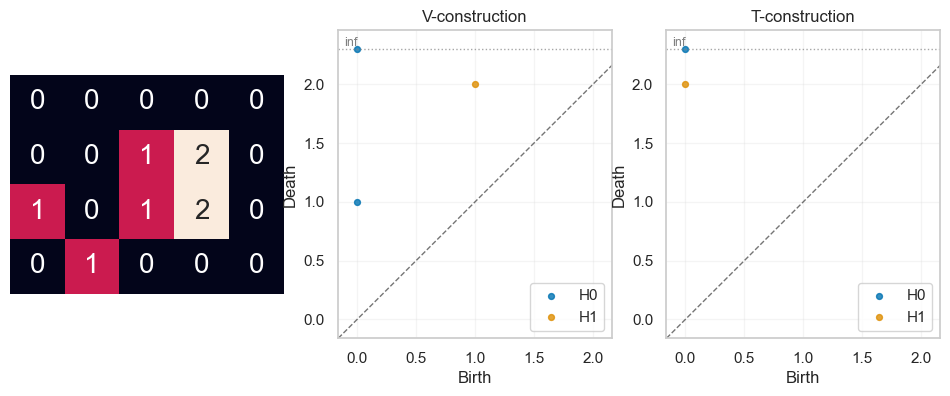

In [56]:
## Simple example showing the difference between V- and T-constructions.

# Define a 2D array.
simple_img=np.array([[0,0,0,0,0],
                      [0,0,1,2,0],
                      [1,0,1,2,0],
                      [0,1,0,0,0]])

# Plot the array.
fig,axs = plt.subplots(1,3,figsize=(12,4))
sns.heatmap(simple_img, annot=True, square=True, yticklabels=False, xticklabels=False, annot_kws={"fontsize":20}, cbar=False, ax=axs[0])

# Compute PH of the 2D array.
pd = cripser.compute_ph(simple_img) # V-construction
pdt = cripser.compute_ph(simple_img, filtration="T") # T-construction

# Each row has the form (dim, birth, death, x1, y1, z1, x2, y2, z2), where (x1, y1, z1) is the creator-cell location and (x2, y2, z2) is the destroyer-cell location.
print("[dim,birth,death,x1,y1,z1,x2,y2,z2]: V-construction")
print(np.where(pd<9, pd, 9).astype(int)) # replace infty with 9 for printing
print("[dim,birth,death,x1,y1,z1,x2,y2,z2]: T-construction")
print(np.where(pdt<9, pdt, 9).astype(int)) # replace infty with 9 for printing

# Plot persistence diagram.
cripser.plot_diagrams(pd, ax=axs[1], title='V-construction')
cripser.plot_diagrams(pdt, ax=axs[2], title='T-construction')
plt.show()

### distance transform

The physical unit for the birth and death in PH is the same as that of the pixel values in the image. (such as the Hounsfield unit (HU) in CT.)

We can transform the image to capture different features of the image.
The distance transform can be used if one wants to capture the scale information in the image as persistence.

[dim,birth,death,x1,y1,z1,x2,y2,z2]
[[ 0 -2 -1  3  3  0  2  3  0]
 [ 0 -1  1  0  0  0  1  0  0]
 [ 0 -3  9  0  6  0  0  0  0]]


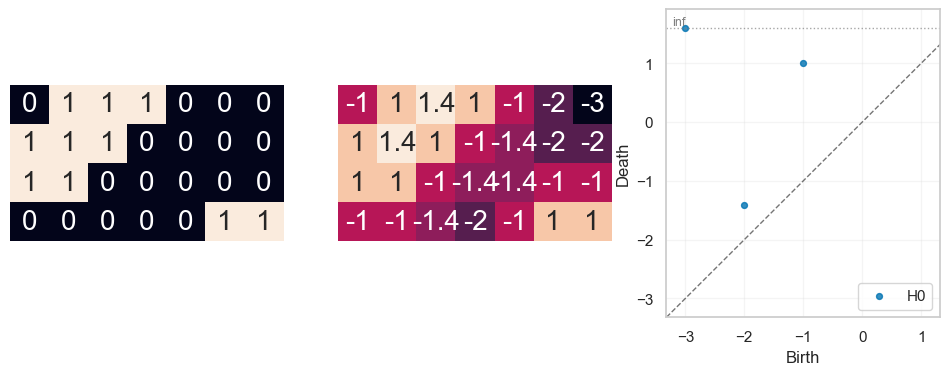

In [57]:
## Simple example with distance transform.
# Define a binary 2D array.
simple_img=np.array([[0,1,1,1,0,0,0],
                      [1,1,1,0,0,0,0],
                      [1,1,0,0,0,0,0],
                      [0,0,0,0,0,1,1]],dtype=bool)

# Apply distance transform.
dt_img = dt(simple_img,signed=True)

# Plot the array.
fig,axs = plt.subplots(1,3,figsize=(12,4))
sns.heatmap(simple_img, annot=True, square=True, yticklabels=False, xticklabels=False, annot_kws={"fontsize":20}, cbar=False, ax=axs[0])
sns.heatmap(dt_img, annot=True, square=True, yticklabels=False, xticklabels=False, annot_kws={"fontsize":20}, cbar=False, ax=axs[1])

# Compute PH of the 2D array (V-construction).
pdt = cripser.compute_ph(dt_img)

# Each row has the form (dim, birth, death, x1, y1, z1, x2, y2, z2), where (x1, y1, z1) is the creator-cell location and (x2, y2, z2) is the destroyer-cell location.
print("[dim,birth,death,x1,y1,z1,x2,y2,z2]")
print(np.where(pdt<9, pdt, 9).astype(int)) # replace infty with 9 for printing

# Plot persistence diagram.
cripser.plot_diagrams(pdt, ax=axs[2])
plt.show()

### grayscale photo

0 255 uint8


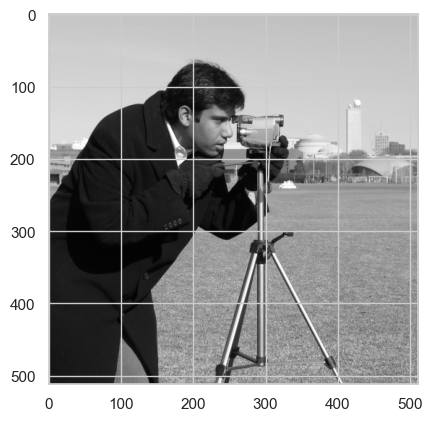

In [58]:
# Load a sample greyscale image.
img = skimage.data.camera()
## If you want to upload your own image in Google Colab:
#from google.colab import files
#img = skimage.color.rgb2gray(io.imread(list(files.upload().keys())[0]))

# Plot.
plt.imshow(img, cmap='gray')
print(np.min(img),np.max(img),img.dtype)

[dim,birth,death,x1,y1,z1,x2,y2,z2]
[[  0.   2.   3. 304. 157.   0. 305. 158.   0.]
 [  0.   2.   3. 306. 157.   0. 313. 154.   0.]
 [  0.   2.   3. 326. 152.   0. 327. 153.   0.]
 [  0.   2.   3. 322. 153.   0. 323. 153.   0.]
 [  0.   2.   3. 319. 153.   0. 320. 153.   0.]]
Betti numbers:  [22963, 13716]
Betti numbers:  [13563, 23286]


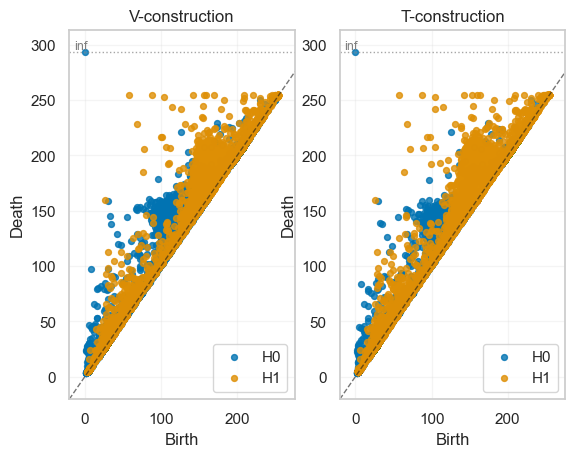

In [59]:
# Compute PH of the sublevel filtration.
# V-construction of the original image (pixel-value filtration).
pd = cripser.compute_ph(img,maxdim=1)

# Each row has the form (dim, birth, death, x1, y1, z1, x2, y2, z2), where (x1, y1, z1) is the creator-cell location and (x2, y2, z2) is the destroyer-cell location.
print("[dim,birth,death,x1,y1,z1,x2,y2,z2]")
print(pd[:5])

# Arrange by homology degree.
pds = [pd[pd[:,0] == i] for i in range(2)]
print("Betti numbers: ",[len(pds[i]) for i in range(len(pds))])

# T-construction of the original image (pixel-value filtration).
pdt = cripser.compute_ph(img,maxdim=1, filtration="T")
pdst = [pdt[pdt[:,0] == i] for i in range(2)]
print("Betti numbers: ",[len(pdst[i]) for i in range(len(pdst))])

## Plot persistence diagram using cripser.
fig,axs = plt.subplots(1,2)
cripser.plot_diagrams(pd, ax=axs[0], title='V-construction')
cripser.plot_diagrams(pdt, ax=axs[1], title='T-construction')

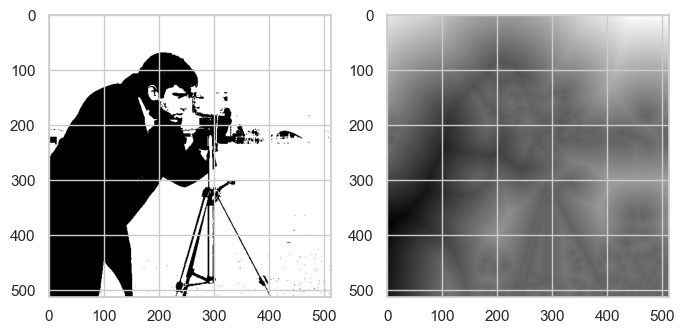

In [60]:
## For greyscale images, there is another notion of persistence besides sublevel filtration.
# The following step binarises the input image and applies a distance transform.
# Sublevel filtration is suitable when pixel values carry semantic meaning (for example, HU values in CT).
# Distance transform is suitable when you are interested in geometric scale.

bw_img = (img >= threshold_otsu(img)) # binarise by Otsu's method
dt_img = dt(img,signed=True)
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(121)
ax.imshow(bw_img,cmap='gray')
ax = fig.add_subplot(122)
ax.imshow(dt_img, cmap='gray')

Betti numbers:  [717, 311]
Betti numbers:  [393, 725]


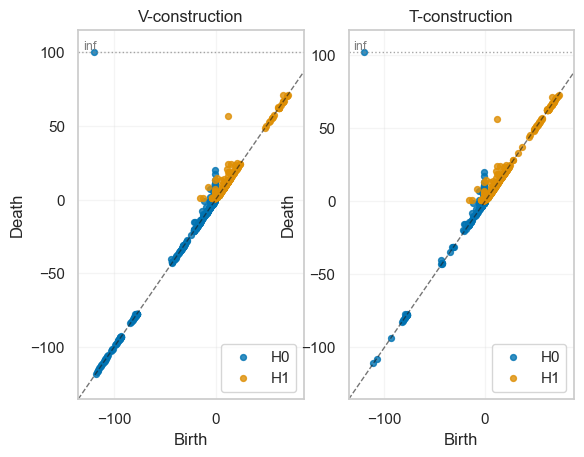

In [61]:
# Compute persistence of the distance transform.
# V-construction of the distance-transformed image.
pd = cripser.compute_ph(dt_img)
pds = [pd[pd[:,0] == i] for i in range(2)]
print("Betti numbers: ",[len(pds[i]) for i in range(len(pds))])

# T-construction of the distance-transformed image.
pdt = cripser.compute_ph(dt_img, filtration="T")
pdst = [pdt[pdt[:,0] == i] for i in range(2)]
print("Betti numbers: ",[len(pdst[i]) for i in range(len(pdst))])

## Plot persistence diagram using cripser.
fig,axs = plt.subplots(1,2)
cripser.plot_diagrams(pd, ax=axs[0], title='V-construction')
cripser.plot_diagrams(pdt, ax=axs[1], title='T-construction')
plt.show()

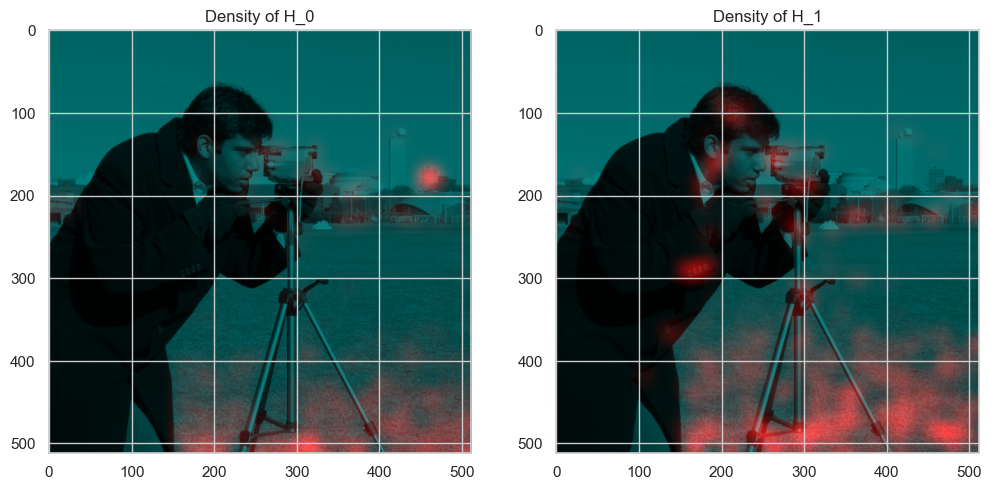

In [62]:
## Plot heat maps for H_0 and H_1 showing the density of cycle birth locations.

pd = cripser.compute_ph(img, maxdim=1)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for i in range(2):
  heat = heat_map(img, pd, h=20, sigma=10, min_birth=10, min_life=30, dimension=i, location='birth')
  heat = (heat / np.max(heat) * 255).astype(np.uint8)
  axs[i].imshow(np.dstack([heat, img // 2, img // 2]))
  axs[i].set_title(f"Density of H_{i}")
plt.show()

### classification example

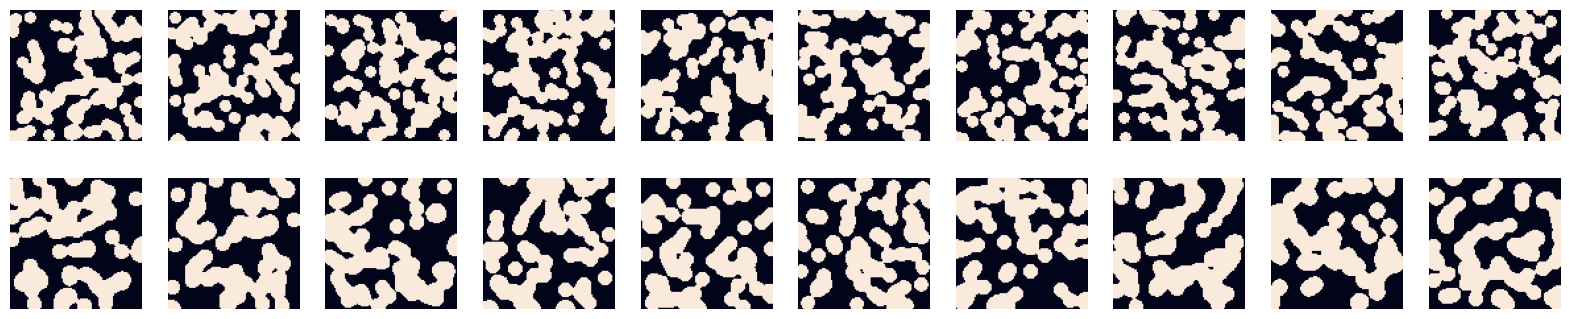

In [63]:
## The usefulness of PH as a feature extractor depends on the problem.
## Let us run a synthetic classification task where PH performs well.


## Create a binary classification problem with random blobs of different sizes.
n = 100
X = [data.binary_blobs(length=100, blob_size_fraction=0.1) for i in range(n)] # class A: small size
X.extend([data.binary_blobs(length=100, blob_size_fraction=0.12) for i in range(n)]) # class B: large size

# Set class labels.
Y = [0 for i in range(n)]
Y.extend([1 for i in range(n)])

# Split into training and test datasets.
(train_idx, test_idx, trainY, testY) = train_test_split(range(len(X)), Y, test_size = 0.3, random_state = 0, stratify=Y)

# Plot.
fig,axs = plt.subplots(2,10,figsize=(20,4))
for i in range(10):
  axs[0,i].imshow(X[i])
  axs[1,i].imshow(X[i+n])
  axs[0,i].axis('off')
  axs[1,i].axis('off')

In [64]:
## Classification using raw pixel values.
# The result is poor because pixel values alone are not sufficiently discriminative.

trainX=[X[i].ravel() for i in train_idx]
testX=[X[i].ravel() for i in test_idx]
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(trainX, trainY)
predY = clf.predict(testX)
print("Confusion matrix\n",confusion_matrix(testY,predY))
print(classification_report(testY,predY))

Confusion matrix
 [[19 11]
 [15 15]]
              precision    recall  f1-score   support

           0       0.56      0.63      0.59        30
           1       0.58      0.50      0.54        30

    accuracy                           0.57        60
   macro avg       0.57      0.57      0.56        60
weighted avg       0.57      0.57      0.56        60



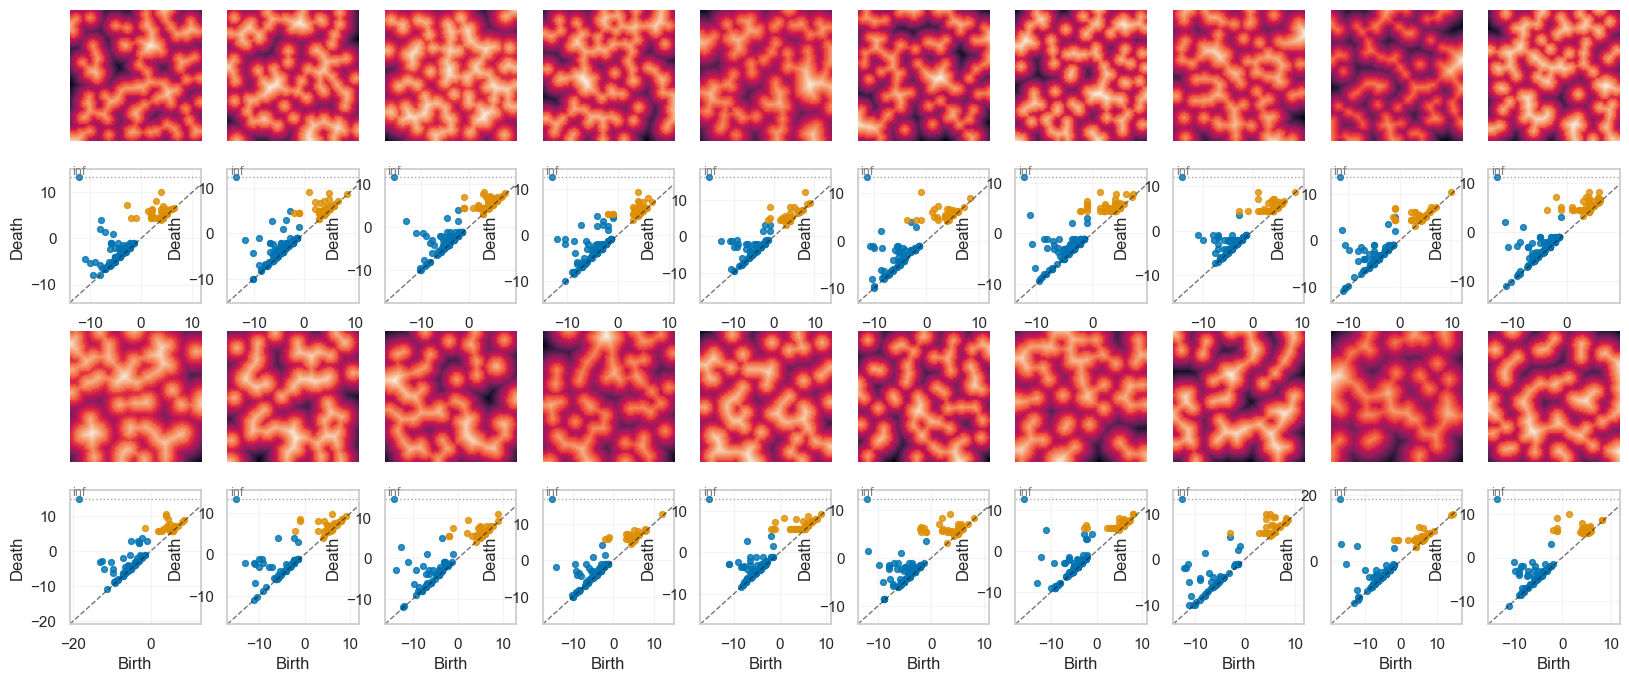

In [65]:
# As size matters in this task, we apply distance transform so that PH captures size information.

pds = []
for i in range(len(X)):
    pd = cripser.compute_ph(dt(X[i],signed=True))    # compute PH of distance transform
    pds.append(pd)

# Plot a few examples.
fig,axs = plt.subplots(4,10,figsize=(20,8))
for i in range(10):
  axs[0,i].imshow(dt(X[i],signed=True))
  axs[0,i].axis('off')
  pd=pds[i]
  cripser.plot_diagrams(pd, ax=axs[1,i], legend=False)
  axs[2,i].imshow(dt(X[i+n],signed=True))
  axs[2,i].axis('off')
  pd=pds[i+n]
  cripser.plot_diagrams(pd, ax=axs[3,i], legend=False)

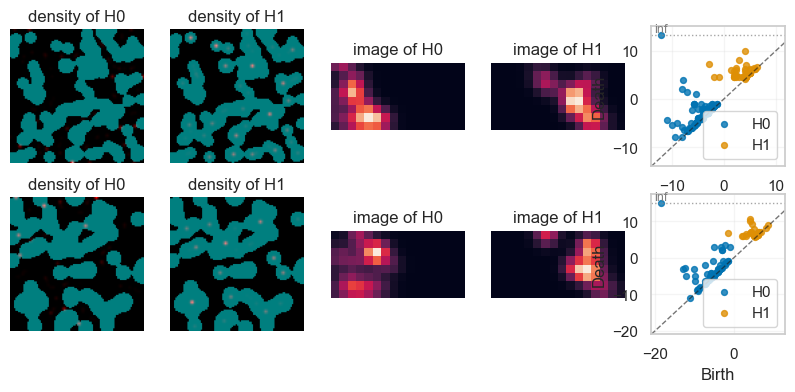

In [66]:
# Plot a subset of the data.
# We use `cripser.persistence_image` with explicit birth/lifetime ranges.

max_life = 8
pixel_size = 1
n_birth_bins = int((2 * max_life) / pixel_size)
n_life_bins = int(max_life / pixel_size)

idx = [0,n]
nn=len(idx)
fig,axs = plt.subplots(nn,5,figsize=(nn*5,4))
for i in range(nn):
  img = X[idx[i]]*255
  pd = pds[idx[i]]
  for d in range(2):
    heat=heat_map(img,pd,h=5,sigma=1,min_life=0,max_life=max_life,min_birth =-max_life,max_birth = max_life,dimension=d,location='death')
    heat = (heat/max(1,np.max(heat))*255).astype(np.uint8)
    axs[i,0+d].imshow(np.dstack([heat,img//2,img//2]))
    axs[i,0+d].set_title("density of H{}".format(d))
    axs[i,0+d].axis('off')
    pim = cripser.persistence_image(
      pd,
      homology_dims=[d],
      n_birth_bins=n_birth_bins,
      n_life_bins=n_life_bins,
      birth_range=(-max_life, max_life),
      life_range=(0, max_life),
    )[0]
    axs[i,2+d].imshow(pim, origin="lower")
    axs[i,2+d].set_title("image of H{}".format(d))
    axs[i,2+d].axis('off')
  cripser.plot_diagrams(pd,ax = axs[i,4])
plt.show()

In [67]:
### Feature extraction via persistence images.
# Use the resulting persistence image as a classification feature.

dim = 1 # which PH dim to look at?
pims_h = []
for i in range(len(X)):
    pd = pds[i]
    pim0 = cripser.persistence_image(
      pd,
      sigma=0.1,
      homology_dims=[dim],
      n_birth_bins=n_birth_bins,
      n_life_bins=n_life_bins,
      birth_range=(-max_life, max_life),
      life_range=(0, max_life),
    )[0]
    pims_h.append(pim0.ravel())

## Classification.
trainX=[pims_h[i] for i in train_idx]
testX=[pims_h[i] for i in test_idx]
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(trainX, trainY)
predY = clf.predict(testX)
print("Confusion matrix\n",confusion_matrix(testY,predY))
print(classification_report(testY,predY))

Confusion matrix
 [[30  0]
 [ 0 30]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        30

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



Important feature: birth around  3.428571428571427 lifetime around  3.2


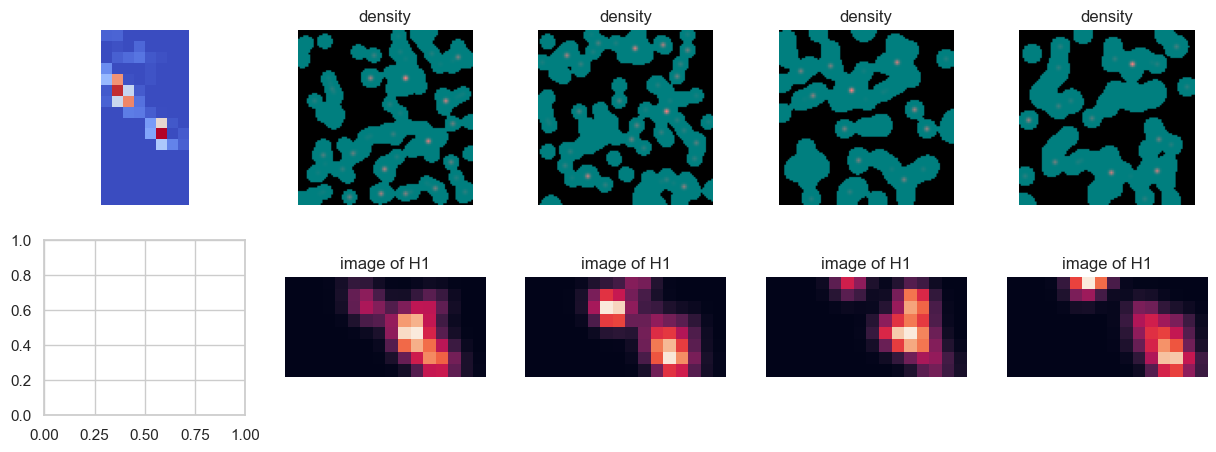

In [68]:
## Identify which variables most influence the decision.
# In this case, the informative region lies in the H_1 persistence image.
# This visualisation helps explain results and suggests mechanisms behind the observed phenomenon.
indices = np.argsort(clf.feature_importances_)
#plt.barh(range(len(indices)), clf.feature_importances_[indices])

idx = [0,1,n,n+1]
nn = len(idx)

fig,axs = plt.subplots(2,nn+1,figsize=(3+nn*3,5))
axs[0,0].imshow(clf.feature_importances_.reshape(pim0.shape).T,origin="lower",cmap='coolwarm')
axs[0,0].axis('off')
most_important = np.unravel_index(indices[-1], shape=pim0.shape)
life,birth = np.meshgrid(np.linspace(0,max_life,pim0.shape[1]),np.linspace(-max_life,max_life,pim0.shape[0]))
b = birth[most_important]
l = life[most_important]
print("Important feature: birth around ", b,"lifetime around ", l)

# Annotate the density of the most influential feature on the image.
# For demonstration, we select a few images from each class.
# The annotation illustrates how the classifier distinguishes the two classes.
for i in range(nn):
  img = X[idx[i]]*255
  pd = pds[idx[i]]
  h = 3*pixel_size
  heat=heat_map(img,pd,h=5,sigma=1,min_life=l-h,max_life=l+h,min_birth =b-h,max_birth = b+h,dimension=dim,location='death')
  heat = (heat/max(1,np.max(heat))*255).astype(np.uint8)
  pim0 = cripser.persistence_image(
    pd,
    sigma=1,
    homology_dims=[dim],
    n_birth_bins=n_birth_bins,
    n_life_bins=n_life_bins,
    birth_range=(-max_life, max_life),
    life_range=(0, max_life),
  )[0]
  axs[0,i+1].imshow(np.dstack([heat,img//2,img//2]))
  axs[0,i+1].set_title("density")
  axs[0,i+1].axis('off')
  axs[1,i+1].imshow(pim0,origin="lower")
  axs[1,i+1].set_title("image of H{}".format(dim))
  axs[1,i+1].axis('off')

plt.show()

## Volume

PH workflow for volumetric (3D) data


(40, 40, 40) float64 0.0--1.0


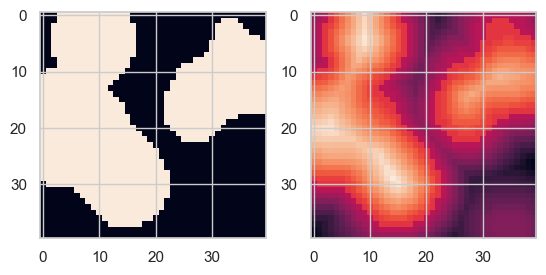

In [ ]:
# Shared setup
VOLUME_IMAGE_DIR = "./images/"

## Set the following values as appropriate for your data.
IMG_DIR = VOLUME_IMAGE_DIR  ## dir containing images for a 3D example; all the images must be of the same dimension

# Create a 3D stack from 2D images.
if os.path.isdir(IMG_DIR):
    from PIL import Image
    # Load image files from a directory and stack them into a float64 3D array.
    input_files = os.path.join(IMG_DIR,"*.jpg")
    files = [f for f in glob.glob(input_files)]
    files.sort(key=lambda val : int(re.sub("\\D", "", val+"0")))
    img3d = np.dstack([Image.open(f).convert('L') for f in files]).astype('f8')
else:
    from skimage.data import binary_blobs
    img3d = np.ascontiguousarray(skimage.util.img_as_float(binary_blobs(40, n_dim=3, blob_size_fraction=0.3)))

## Apply distance transform.
img3d_dt = dt(img3d,signed=True)

fig,axs = plt.subplots(1,2)
axs[0].imshow(img3d[:,:,img3d.shape[-1]//2])
axs[1].imshow(img3d_dt[:,:,img3d_dt.shape[-1]//2])
print(img3d.shape, img3d.dtype, f"{np.min(img3d)}--{np.max(img3d)}")

In [69]:
# Interactive view of 3D slices.
explore_slices(img3d)

interactive(children=(IntSlider(value=20, description='plane', max=39), Output()), _dom_classes=('widget-inter…

<function __main__.explore_slices.<locals>.display_slice(plane=20)>

Betti numbers:  [122, 107, 21]
Betti numbers:  [30, 104, 114]


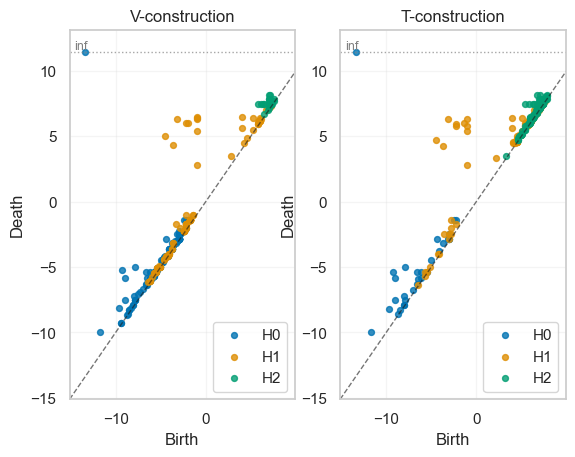

In [70]:
# Sublevel filtration of the original image (pixel-value filtration).
# V-construction.
pd = cripser.compute_ph(img3d_dt)
pds = [pd[pd[:,0] == i] for i in range(3)]
print("Betti numbers: ",[len(pds[i]) for i in range(len(pds))])

# T-construction of the original image (pixel-value filtration).
pdt = cripser.compute_ph(img3d_dt, filtration="T")
pdst = [pdt[pdt[:,0] == i] for i in range(3)]
print("Betti numbers: ",[len(pdst[i]) for i in range(len(pdst))])

## Plot persistence diagram using cripser.
fig,axs = plt.subplots(1,2)
cripser.plot_diagrams(pd, ax=axs[0], title='V-construction')
cripser.plot_diagrams(pdt, ax=axs[1], title='T-construction')
plt.show()

In [73]:
%%timeit -r 1 -n 5
# Compute PH for the T-construction with GUDHI.
gd = gudhi.CubicalComplex(top_dimensional_cells=img3d_dt)
#gd = gudhi.CubicalComplex(vertices=img)
#    gd.compute_persistence()
res = gd.persistence(2,0) # coeff = 2
print("Betti numbers: ", gd.persistent_betti_numbers(np.inf,-np.inf))

Betti numbers:  [31, 71, 71, 0]
Betti numbers:  [31, 71, 71, 0]
Betti numbers:  [31, 71, 71, 0]
Betti numbers:  [31, 71, 71, 0]
Betti numbers:  [31, 71, 71, 0]
223 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)


In [74]:
%%timeit -r 1 -n 5
# Compute PH for the T-construction with CubicalRipser (faster).
pdt = cripser.compute_ph(img3d_dt, filtration="T")
pdst = [pdt[pdt[:,0] == i] for i in range(3)]
print("Betti numbers: ",[len(pdst[i]) for i in range(len(pdst))])

Betti numbers:  [31, 71, 71]
Betti numbers:  [31, 71, 71]
Betti numbers:  [31, 71, 71]
Betti numbers:  [31, 71, 71]
Betti numbers:  [31, 71, 71]
33.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)


## Time series

Time series is a 1D image, so the techniques in the previous section apply straightforwardly. Here, we see examples with different tasks.

Transform time series into topological features and estimate periods via regression.

時系列を位相特徴へ変換し、回帰によって周期を推定します。

In [250]:
# Shared setup
# Common imports, constants, and helper utilities for this section.
TIME_SERIES_SEED = 42
np.random.seed(TIME_SERIES_SEED)

from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import gudhi.point_cloud.timedelay


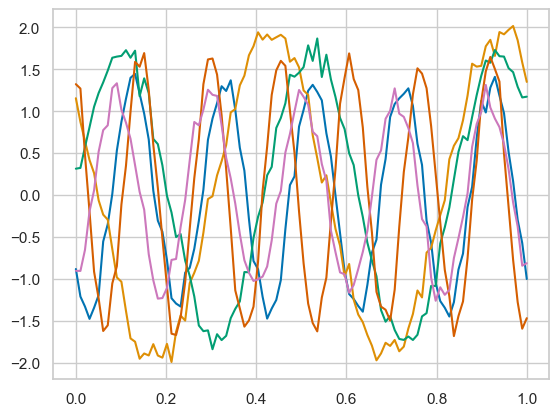

In [251]:
# Synthetic example.
# Goal: infer the period of a sine wave from noisy data.


# Generate noisy sine-wave signals.
n=200  # number of samples
t = np.linspace(0,1,100)
a=np.random.uniform(low=1,high=2,size=n)  # amplitude
b=np.random.uniform(low=1.5,high=7,size=n) # period <= our target for regression
c=np.random.uniform(low=-np.pi,high=np.pi,size=n) # phase
# Generate sine-wave signals with varying parameters and noise.
X = [a[i]*np.sin(2*np.pi*b[i]*t+c[i]) + np.random.normal(scale=0.1,size=len(t)) for i in range(n)]
for i in range(5):
    plt.plot(t,X[i])
plt.show()

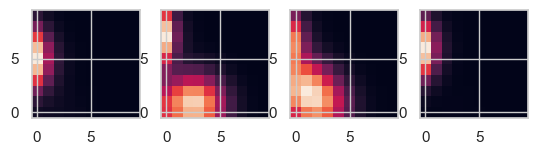

In [73]:
## Compute PH and vectorise with persistence images.

birth_range = (0, 5)
life_range = (0, 5)
bin_size = 0.5
n_birth_bins = int((birth_range[1] - birth_range[0]) / bin_size)
n_life_bins = int((life_range[1] - life_range[0]) / bin_size)

pds, pims = [], []
for i in range(len(X)):
    pd_pairs = np.clip(cripser.compute_ph(X[i])[:,1:3],a_min=-2,a_max=2)  # clip min/max birth/death
    pds.append(pd_pairs)
    ph = np.column_stack([np.zeros((len(pd_pairs), 1)), pd_pairs])
    pims.append(
        cripser.persistence_image(
            ph,
            homology_dims=[0],
            n_birth_bins=n_birth_bins,
            n_life_bins=n_life_bins,
            birth_range=birth_range,
            life_range=life_range,
        )[0]
    )
for i in range(4):   # plot persistence images for the first four samples
    ax = plt.subplot(240+i+1)
    ax.imshow(pims[i],origin='lower')
plt.show()

MSE train : 0.056, test : 0.063
R2 train : 0.978, test : 0.977


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.435e+00, tolerance: 3.507e-02
  model = cd_fast.enet_coordinate_descent(


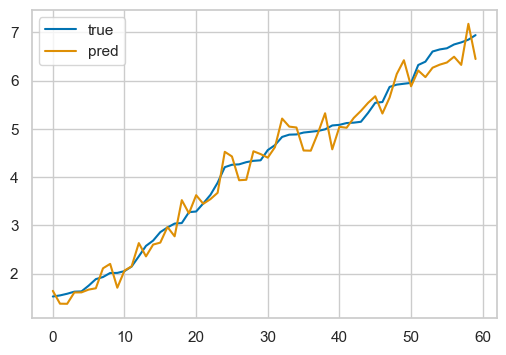

In [74]:
# Linear regression for period prediction (input: PH features, output: period).
# Train/test split.
(trainX, testX, trainY, testY) = train_test_split(np.array(pims).reshape(n,-1), b, test_size = 0.3, random_state = 0) # use PH features

# Fit the model.
clf = linear_model.Lasso(alpha=0.0001,max_iter=10000)
clf.fit(trainX, trainY)

# Prediction: the result is reasonably good.
trainPred = clf.predict(trainX)
testPred = clf.predict(testX)
print('MSE train : %.3f, test : %.3f' % (mean_squared_error(trainY,trainPred), mean_squared_error(testY,testPred)) )
print('R2 train : %.3f, test : %.3f' % (r2_score(trainY,trainPred), r2_score(testY,testPred)) )

# Sort the test data for visualisation.
idx = np.argsort(testY)
testY=testY[idx]
testPred=testPred[idx]

plt.figure(figsize=(6,4))
plt.plot(testY,label="true")
plt.plot(testPred, label="pred")
plt.legend()
plt.show()

MSE train : 0.735, test : 6.369
R2 train : 0.707, test : -1.303


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.746e+01, tolerance: 3.507e-02
  model = cd_fast.enet_coordinate_descent(


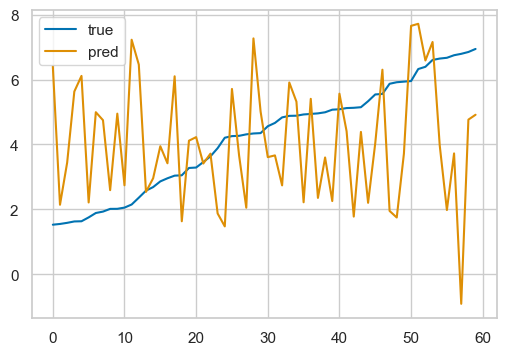

In [76]:
## Using the original data directly, instead of PH features, gives worse results.
# Input: original time series; output: period.

X_flat = np.array(X).reshape(n, -1)

(trainX, testX, trainY, testY) = train_test_split(X, b, test_size = 0.3, random_state = 0)  # see what happens if we use the input data directly

# Fit the model.
clf = linear_model.Lasso(alpha=0.0001,max_iter=10000)
clf.fit(trainX, trainY)

# Prediction: the result is much worse.
trainPred = clf.predict(trainX)
testPred = clf.predict(testX)
print('MSE train : %.3f, test : %.3f' % (mean_squared_error(trainY,trainPred), mean_squared_error(testY,testPred)) )
print('R2 train : %.3f, test : %.3f' % (r2_score(trainY,trainPred), r2_score(testY,testPred)) )

# Sort the test data for visualisation.
idx = np.argsort(testY)
testY=testY[idx]
testPred=testPred[idx]

plt.figure(figsize=(6,4))
plt.plot(testY,label="true")
plt.plot(testPred, label="pred")
plt.legend()
plt.show()

MSE train : 0.262, test : 0.352
R2 train : 0.896, test : 0.873


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.774e+01, tolerance: 3.507e-02
  model = cd_fast.enet_coordinate_descent(


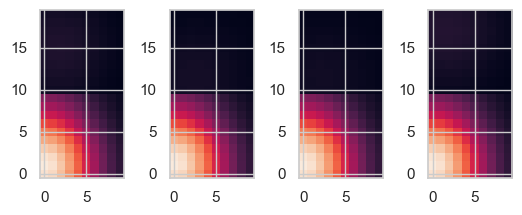

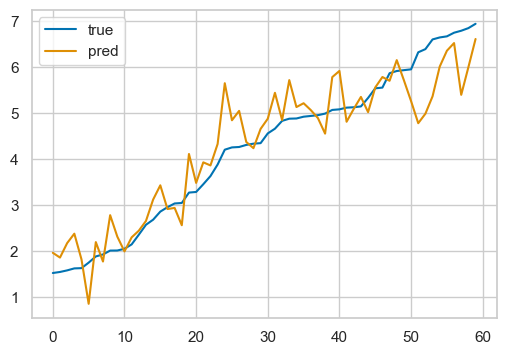

In [77]:
# Rather than computing PH directly on the time series over the real line,
# we can use Takens embedding to convert the time series into a geometric object (an approximate attractor),
# and analyse its topological features via PH. In this case, the result is not very good.
# Input: Takens-embedded time series; output: period.

embedder = gudhi.point_cloud.timedelay.TimeDelayEmbedding(dim=2, delay=3, skip=1)
X_takens = embedder.transform(X)

birth_range = (0,2)
life_range = (0,2)
bin_size = 0.2
n_birth_bins = int((birth_range[1] - birth_range[0]) / bin_size)
n_life_bins = int((life_range[1] - life_range[0]) / bin_size)

pds, pims = [], []
for i in range(len(X)):
    pd = ripser(X_takens[i])['dgms']    # compute PH
    ph0 = np.column_stack([np.zeros((len(pd[0]), 1)), np.clip(pd[0],a_min=0,a_max=2)])
    ph1 = np.column_stack([np.zeros((len(pd[1]), 1)), np.clip(pd[1],a_min=0,a_max=2)])
    pim0 = cripser.persistence_image(
        ph0,
        homology_dims=[0],
        n_birth_bins=n_birth_bins,
        n_life_bins=n_life_bins,
        birth_range=birth_range,
        life_range=life_range,
    )[0] # PH_0
    pim1 = cripser.persistence_image(
        ph1,
        homology_dims=[0],
        n_birth_bins=n_birth_bins,
        n_life_bins=n_life_bins,
        birth_range=birth_range,
        life_range=life_range,
    )[0] # PH_1
    pims.append(np.concatenate([pim0,pim1])) # combine PH_0 and PH_1 to make a feature vector
for i in range(4):   # plot persistence images
    ax = plt.subplot(240+i+1)
    ax.imshow(pims[i],origin='lower')

## Linear regression for period prediction.
# Train/test split.
(trainX, testX, trainY, testY) = train_test_split(np.array(pims).reshape(n,-1), b, test_size = 0.3, random_state = 0) # use PH features

# Fit the model.
clf = linear_model.Lasso(alpha=0.0001,max_iter=10000)
clf.fit(trainX, trainY)

# Prediction: the result is worse than without embedding.
# This is reasonable, because with the direct signal the 0th Betti number closely reflects frequency.
# Takens embedding is useful for signals from deterministic dynamical systems,
# as it reconstructs the underlying attractors.

trainPred = clf.predict(trainX)
testPred = clf.predict(testX)
print('MSE train : %.3f, test : %.3f' % (mean_squared_error(trainY,trainPred), mean_squared_error(testY,testPred)) )
print('R2 train : %.3f, test : %.3f' % (r2_score(trainY,trainPred), r2_score(testY,testPred)) )

# Sort the test data for visualisation.
idx = np.argsort(testY)
testY=testY[idx]
testPred=testPred[idx]

plt.figure(figsize=(6,4))
plt.plot(testY,label="true")
plt.plot(testPred, label="pred")
plt.legend()
plt.show()

MSE train : 0.083, test : 0.571
R2 train : 0.967, test : 0.794


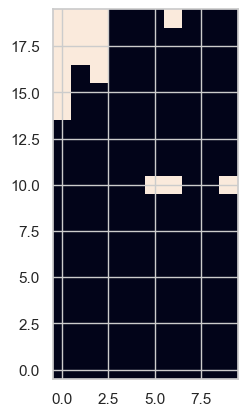

In [78]:
## Non-linear feature selection with Random Forest (this may take a few minutes).
## Identify which persistence-image entries have the strongest impact on prediction.
## This indicates which birth/lifetime ranges are important for the current task.

(trainX, testX, trainY, testY) = train_test_split(np.array(pims).reshape(n,-1), b, test_size = 0.3, random_state = 0) # use PH features

# Feature selection with SelectFromModel.
rf_selector = RandomForestRegressor(n_jobs=-1, n_estimators=200, max_depth=12, random_state=TIME_SERIES_SEED)
feat_selector = SelectFromModel(rf_selector, threshold="median")
feat_selector.fit(trainX, trainY)

X_filtered = feat_selector.transform(trainX)
testX_filtered = feat_selector.transform(testX)

rf = RandomForestRegressor(n_jobs=-1, n_estimators=200, max_depth=12, random_state=TIME_SERIES_SEED)
rf.fit(X_filtered, trainY)
trainPred = rf.predict(X_filtered)
testPred = rf.predict(testX_filtered)
print('MSE train : %.3f, test : %.3f' % (mean_squared_error(trainY,trainPred), mean_squared_error(testY,testPred)) )
print('R2 train : %.3f, test : %.3f' % (r2_score(trainY,trainPred), r2_score(testY,testPred)) )

# Plot selected regions in the persistence image.
selected_mask = feat_selector.get_support().reshape(pims[0].shape)
plt.imshow(selected_mask,origin='lower')
plt.show()


  0%|          | 0/100 [00:00<?, ?it/s]

MSE train : 0.006, test : 0.009
R2 train : 0.998, test : 0.997


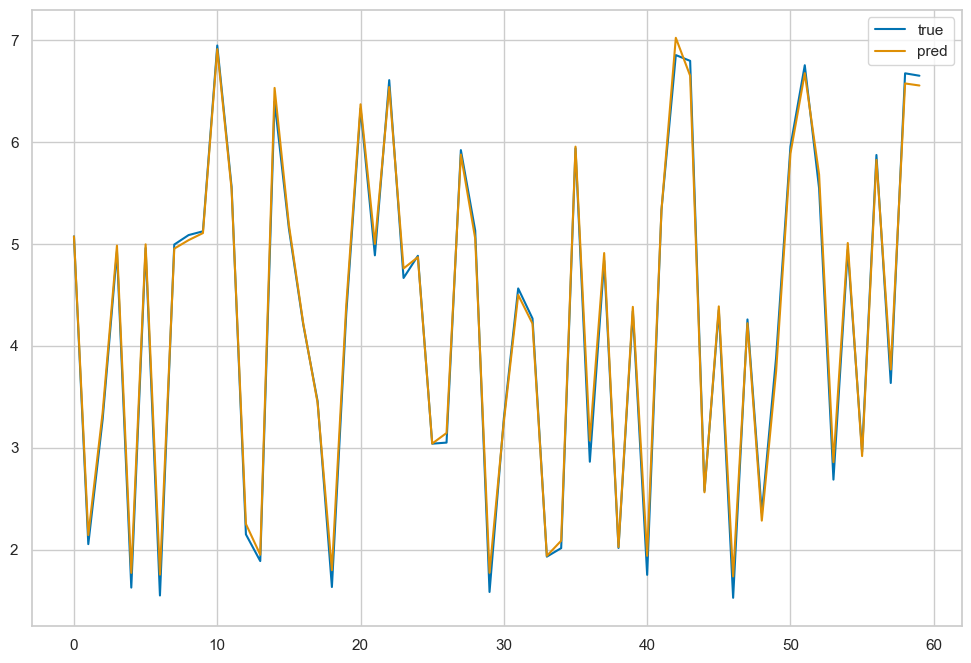

In [ ]:

## Compare performance with an LSTM (a widely used recurrent neural network).
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm

# Reproducibility for optimisation.
torch.manual_seed(0)

# Train/test split.
(trainX, testX, trainY, testY) = train_test_split(
    np.array(X).reshape(n, -1, 1),
    b,
    test_size=0.3,
    random_state=0,
)

# Normalise each sample (helps remove amplitude/offset effects).
trainX = (trainX - trainX.mean(axis=1, keepdims=True)) / (trainX.std(axis=1, keepdims=True) + 1e-8)
testX = (testX - testX.mean(axis=1, keepdims=True)) / (testX.std(axis=1, keepdims=True) + 1e-8)

# Normalise target for stable optimisation.
y_mean, y_std = trainY.mean(), trainY.std() + 1e-8
trainY_norm = (trainY - y_mean) / y_std

trainX_t = torch.tensor(trainX, dtype=torch.float32)
testX_t = torch.tensor(testX, dtype=torch.float32)
trainY_t = torch.tensor(trainY_norm, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(trainX_t, trainY_t), batch_size=20, shuffle=True)


class LSTMRegressor(nn.Module):
    def __init__(self, hidden_size=128):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, batch_first=True)
        self.head = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.head(out[:, -1, :]).squeeze(-1)


model = LSTMRegressor(hidden_size=128)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

# Train the model.
epochs = tqdm(range(100))
for epoch in epochs:
    model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        epochs.set_postfix(loss=loss.item())

# Prediction: the LSTM performs better.
model.eval()
with torch.no_grad():
    trainPred = model(trainX_t).numpy().reshape(-1) * y_std + y_mean
    testPred = model(testX_t).numpy().reshape(-1) * y_std + y_mean

print('MSE train : %.3f, test : %.3f' % (mean_squared_error(trainY, trainPred), mean_squared_error(testY, testPred)))
print('R2 train : %.3f, test : %.3f' % (r2_score(trainY, trainPred), r2_score(testY, testPred)))

plt.figure(figsize=(12, 8))
plt.plot(testY, label="true")
plt.plot(testPred, label="pred")
plt.legend()
plt.show()


# Dimension reduction
Dimension reduction techniques can be used for:
- Visualisation
- Preprocessing for regressor/classifier
- Outlier detection

### Section Card

**English**
- Objective: Project high-dimensional features into low dimensions and compare structure and class separability.
- Input: Digits dataset.
- Output: Comparative plots for PCA, t-SNE, UMAP, and Mapper.

**日本語**
- 目的: 高次元特徴を低次元に射影し、構造とクラス分離性を比較します。
- 入力: Digits データセット。
- 出力: PCA・t-SNE・UMAP・Mapper のプロット。


In [255]:
# Shared setup
# Common imports, constants, and helper utilities for this section.
import sklearn
import sklearn.datasets
from sklearn import manifold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
from mpl_toolkits.axes_grid1 import ImageGrid
import umap
import networkx as nx

sns.set_style("whitegrid")

(901, 64)


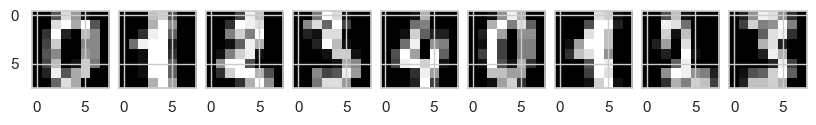

In [256]:
# Load demo data: handwritten digits.
# Use seaborn to improve matplotlib styling.
sns.set_style("whitegrid")

X,Y = sklearn.datasets.load_digits(n_class=5,return_X_y=True)
print(X.shape)
num_disp=9
fig = plt.figure(figsize=(10, 2))
grid = ImageGrid(fig, 111,nrows_ncols=(1, num_disp),axes_pad=0.1)
for ax,x in zip(grid, X[:num_disp]):
    ax.imshow(x.reshape(8,8),cmap="gray")

### Visualisation

### PCA

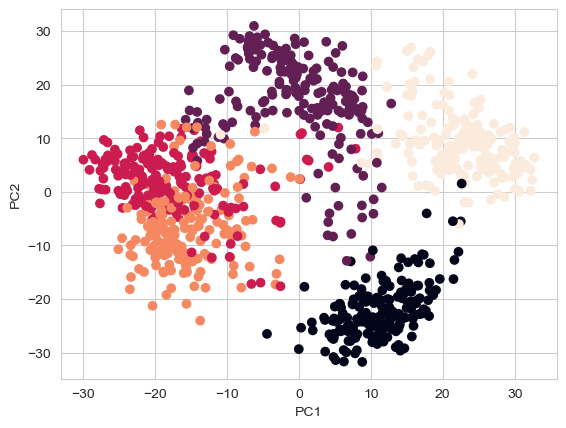

In [83]:
## PCA: still a strong baseline, although some classes overlap (indicated by point colour).
pca = PCA(n_components=3)
X_pca = pca.fit(X).transform(X)
# Plot the first and second principal components.
plt.scatter(X_pca[:,0],X_pca[:,1],c=Y)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

### t-SNE

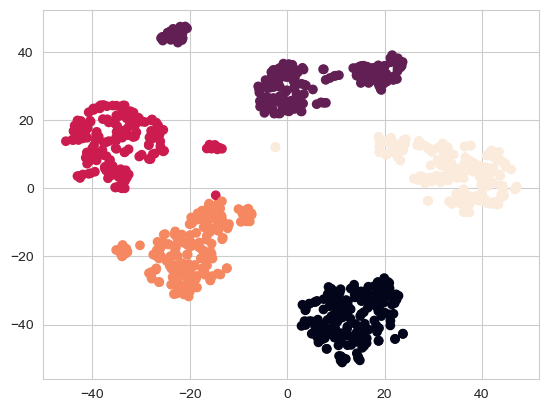

In [84]:
# t-SNE: a popular method; excellent for preprocessing, but component meaning is less interpretable.
X_tsne = manifold.TSNE(n_components=2,perplexity=20).fit_transform(X)
plt.scatter(X_tsne[:,0],X_tsne[:,1],c=Y)

### umap

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


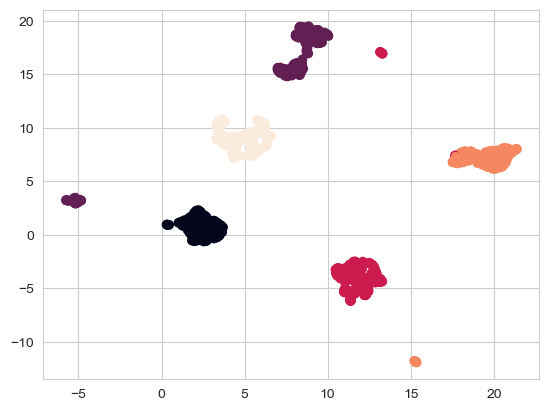

In [86]:
# UMAP (Uniform Manifold Approximation and Projection): projects vectors while preserving local topology.
X_umap = umap.UMAP(n_components=2, n_neighbors=5, metric='euclidean').fit_transform(X)
plt.scatter(X_umap[:,0],X_umap[:,1],c=Y)

### Mapper

In [ ]:
## Mapper: useful for revealing rich topology, but difficult to tune.
# This visualisation does not run in Google Colab; please use Jupyter Notebook.
import kmapper
import kmapper.jupyter

km = kmapper.KeplerMapper()
X_std = StandardScaler().fit_transform(X)   # standardise
f = km.project(X_std,projection="sum") # we have to choose a 1-dim projection
graph = km.map(lens=f, X=X_std, clusterer=sklearn.cluster.DBSCAN(metric="cosine",algorithm='auto', eps=0.3, leaf_size=10))
nx.draw(kmapper.adapter.to_nx(graph))
#km.visualize(graph, color_function=Y, custom_tooltips=Y, path_html="kepler-mapper-output.html") # To download the output, look at the beginning of this note
km.visualize(graph, custom_tooltips=Y, path_html="kepler-mapper-output.html") # To download the output, look at the beginning of this note
print("Download kepler-mapper-output.html and open it with a browser to see the results.")
# The richer visualisation below does not run in Google Colab.
# Download `kepler-mapper-output.html` and open it locally in a browser.
#kmapper.jupyter.display(path_html="kepler-mapper-output.html")

## Preprocess for Classification

### Section Card

**English**
- Objective: Compare how dimensionality reduction and PH features affect classification performance.
- Input: Raw pixel features, UMAP features, and PH-image features.
- Output: Confusion matrices and classification reports.

**日本語**
- 目的: 次元削減と PH 特徴が分類性能に与える影響を比較します。
- 入力: 生の画素特徴、UMAP 特徴、PH 画像特徴。
- 出力: 混同行列と分類レポート。


In [ ]:
# Shared setup
# Common imports, constants, and helper utilities for this section.
import sklearn.datasets
import umap
from scipy.ndimage import distance_transform_edt
from skimage.filters import threshold_otsu
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

CLASSIFICATION_RANDOM_STATE = 0
X, Y = sklearn.datasets.load_digits(n_class=5, return_X_y=True)
print(f"Loaded digits for classification section: {X.shape}")

In [87]:
## Classification with Random Forest.
# First, use the vector data directly (image pixel values).

# Train/test split.
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.3, random_state = CLASSIFICATION_RANDOM_STATE)

clf = RandomForestClassifier(max_depth=2, random_state=CLASSIFICATION_RANDOM_STATE)
clf.fit(trainX, trainY)
predY = clf.predict(testX)

# Classification results.
print("Confusion matrix\n",confusion_matrix(testY,predY))
print(classification_report(testY,predY))

Confusion matrix
 [[52  0  0  0  0]
 [ 0 51  2  5  3]
 [ 0  2 54  3  0]
 [ 0  1  3 47  1]
 [ 1  0  0  0 46]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        52
           1       0.94      0.84      0.89        61
           2       0.92      0.92      0.92        59
           3       0.85      0.90      0.88        52
           4       0.92      0.98      0.95        47

    accuracy                           0.92       271
   macro avg       0.92      0.93      0.92       271
weighted avg       0.92      0.92      0.92       271



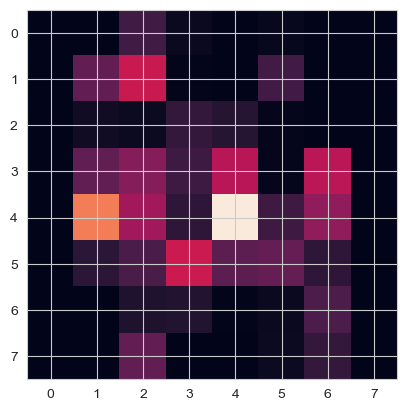

In [88]:
## Identify which variables most influence the decision.
# Here, inspect which pixels are most important for distinguishing digits.
indices = np.argsort(clf.feature_importances_)
#plt.barh(range(len(indices)), clf.feature_importances_[indices])
plt.imshow(clf.feature_importances_.reshape(8,8))

In [89]:
## Next, reduce dimensionality (64 -> 5) and classify.
# You should observe improved accuracy.
X_umap = umap.UMAP(n_components=5, n_neighbors=5, metric='euclidean').fit_transform(X)
(trainX, testX, trainY, testY) = train_test_split(X_umap, Y, test_size = 0.3, random_state = CLASSIFICATION_RANDOM_STATE)
clf = RandomForestClassifier(max_depth=2, random_state=CLASSIFICATION_RANDOM_STATE)
clf.fit(trainX, trainY)
predY = clf.predict(testX)
print("Confusion matrix\n",confusion_matrix(testY,predY))
print(classification_report(testY,predY))

Confusion matrix
 [[52  0  0  0  0]
 [ 0 61  0  0  0]
 [ 0  0 59  0  0]
 [ 0  0  0 52  0]
 [ 0  0  0  0 47]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        52
           1       1.00      1.00      1.00        61
           2       1.00      1.00      1.00        59
           3       1.00      1.00      1.00        52
           4       1.00      1.00      1.00        47

    accuracy                           1.00       271
   macro avg       1.00      1.00      1.00       271
weighted avg       1.00      1.00      1.00       271



In [91]:
## For comparison, use persistence images as features for classification.
# In this case, PH alone is insufficient; only digit 0 is classified with reasonable accuracy.
# It is very important to note that TDA does not replace conventional methods.
# In practice, TDA alone is often weaker, so it should be used as a complementary analysis technique.
birth_range = (0,3)
life_range = (0,3)
bin_size = 0.5
n_birth_bins = int((birth_range[1] - birth_range[0]) / bin_size)
n_life_bins = int((life_range[1] - life_range[0]) / bin_size)

pds, pims_h0, pims_h1 = [], [], []
for i in range(len(X)):
    img = X[i].reshape(8,8)
    bw_img = (img >= threshold_otsu(img))
    dt_img = distance_transform_edt(~bw_img)
    pd = cripser.compute_ph(dt_img)    # compute PH of distance transform
    pd[:,1:3] = np.clip(pd[:,1:3],a_min=0,a_max=3) # clip min/max birth/death
    pds.append(pd)
    pim0 = cripser.persistence_image(
        pd,
        homology_dims=[0],
        n_birth_bins=n_birth_bins,
        n_life_bins=n_life_bins,
        birth_range=birth_range,
        life_range=life_range,
    )[0]
    pim1 = cripser.persistence_image(
        pd,
        homology_dims=[1],
        n_birth_bins=n_birth_bins,
        n_life_bins=n_life_bins,
        birth_range=birth_range,
        life_range=life_range,
    )[0]
    pims_h0.append(pim0.ravel()) # vectorise by persistence image
    pims_h1.append(pim1.ravel()) # vectorise by persistence image

(trainX, testX, trainY, testY) = train_test_split(pims_h1, Y, test_size = 0.3, random_state = CLASSIFICATION_RANDOM_STATE)
clf = RandomForestClassifier(max_depth=2, random_state=CLASSIFICATION_RANDOM_STATE)
clf.fit(trainX, trainY)
predY = clf.predict(testX)
print("Confusion matrix\n",confusion_matrix(testY,predY))
print(classification_report(testY,predY))

Confusion matrix
 [[43  0  0  9  0]
 [ 0  0  0 61  0]
 [ 0  0  0 59  0]
 [ 1  0  0 51  0]
 [ 5  0  0 42  0]]
              precision    recall  f1-score   support

           0       0.88      0.83      0.85        52
           1       0.00      0.00      0.00        61
           2       0.00      0.00      0.00        59
           3       0.23      0.98      0.37        52
           4       0.00      0.00      0.00        47

    accuracy                           0.35       271
   macro avg       0.22      0.36      0.24       271
weighted avg       0.21      0.35      0.23       271



/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"

## Clustering

### Section Card

**English**
- Objective: clustering with ToMATo.
- Input: 2D point clouds and images.
- Output: Cluster assignments and segmentation visualisations.

**日本語**
- 目的: ToMATo を用いた位相的クラスタリング
- 入力: 2D 点群と画像。
- 出力: クラスタ割当とセグメンテーション可視化。


In [87]:
# Shared setup
# Common imports, constants, and helper utilities for this section.
import tomaster
import sklearn.datasets
import skimage

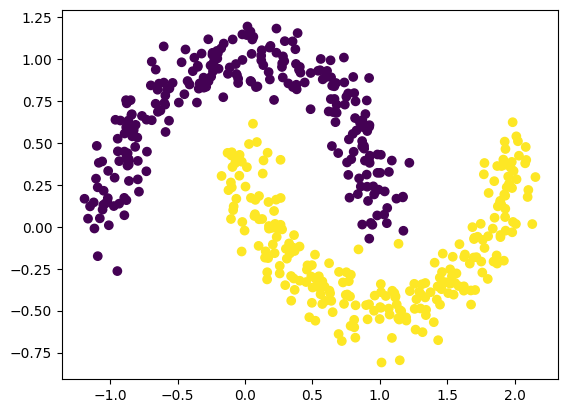

In [ ]:
## ToMATo (Topological Mode Analysis Tool).
# A less widely known application of persistent homology is clustering.
# Input: a graph with real-valued vertices; output: vertex clustering.
X,_ = sklearn.datasets.make_moons(n_samples=500, noise=0.1)
clusters = tomaster.tomato(points = X, k=10, n_clusters=2)
plt.scatter(*X.T, c=clusters)
# Compare with the examples at https://scikit-learn.org/stable/modules/clustering.html.

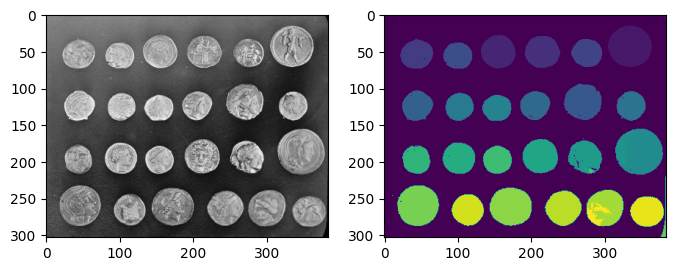

In [ ]:
## ToMATo applied to image segmentation.
# This is a demonstration; there are better methods for routine segmentation tasks.
img = skimage.data.coins()
clusters = tomaster.tomato_img(img, spatial_weight=1, k=10, n_clusters=30)
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(121)
ax.imshow(img,cmap='gray')
ax = fig.add_subplot(122)
ax.imshow(clusters)

# Coordination with PyTorch

### Section Card

**English**
- Objective: Integrate PH-based loss terms into optimisation pipelines.
- Images, point clouds, and graph embeddings.

**日本語**
- 目的: PH ベースの損失項を最適化パイプラインへ組み込む方法を学びます。
- 画像・点群・グラフ埋め込み。


In [ ]:
# Shared setup
# Common imports, constants, and helper utilities for this section.
from tqdm.auto import tqdm
import torch
import torch.optim as optim
from IPython.display import clear_output, display, update_display
import networkx as nx

import cripser
from cripser.rips_utils import compute_ph as compute_ph_rips

TORCH_SEED = 42
torch.manual_seed(TORCH_SEED)
np.random.seed(TORCH_SEED)

# Device configuration.
# Use CUDA when available if you intend to run on GPU.
device = "cpu"

# Runtime note.
# CPU is usually faster for these small-scale examples.
print("Device", device)

def plot_loss(losses, ax):
    ax.clear()
    for key, value in losses.items():
        if key != "epoch":
            ax.plot(losses["epoch"], value, label=key)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_yscale('log')
    ax.legend()
    ax.grid(True)

# Parameters.
# パラメータ
eps = 1e-8


def sample_from_disk(n, r=0.0, R=1.0, seed=None):
    """Sample n points uniformly from an annulus/disk in 2D."""
    rng = np.random.default_rng(seed)
    theta = rng.uniform(0.0, 2.0 * np.pi, size=n)
    radii = np.sqrt(rng.uniform(r * r, R * R, size=n))
    return np.stack((radii * np.cos(theta), radii * np.sin(theta)), axis=1)


def sample_from_sphere(n, d=1, seed=None):
    """Sample n points uniformly on S^d embedded in R^(d+1)."""
    rng = np.random.default_rng(seed)
    x = rng.normal(size=(n, d + 1))
    x /= (np.linalg.norm(x, axis=1, keepdims=True) + 1e-12)
    return x


def sample_from_unit_cube(n, d=2, low=-1.0, high=1.0, seed=None):
    rng = np.random.default_rng(seed)
    return rng.uniform(low, high, size=(n, d))


def finite_diagram(ph_tensor, dim):
    mask = (
        (ph_tensor[:, 0].to(torch.int64) == int(dim))
        & torch.isfinite(ph_tensor[:, 1])
        & torch.isfinite(ph_tensor[:, 2])
    )
    return ph_tensor[mask, 1:3]


Device cpu


## Image optimisation

H0 suppression example: start from an image with many bright blobs, then optimise pixel values so **finite H0 features disappear** (i.e., no persistent connected components in superlevel PH).


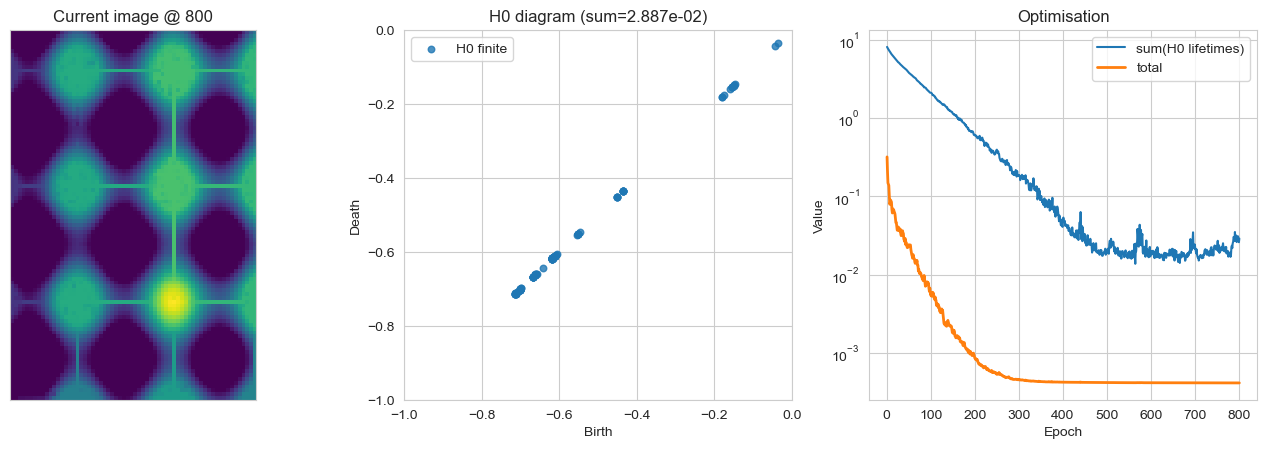

  0%|          | 0/800 [00:00<?, ?it/s]

In [222]:
# Parameters.
n_iterations = 800
disp_interval = 20
lr = 1e-2
lambda_l2 = 1e-2

# Build an initial image with many bright blobs.
n, m = 96, 64
yy, xx = np.mgrid[-5:5:n*1j, 1:9:m*1j]

X = np.cos(2*xx) - np.sin(2*yy) + 0.1*xx
X = X + np.random.normal(scale=0.01, size=X.shape)
X = X / (X.max() + 1e-8)

# Optimisation parameter tensor.
X0 = torch.as_tensor(X, dtype=torch.float32, device=device)
X = torch.nn.Parameter(X0.clone(), requires_grad=True)

optimizer = optim.Adam([X], lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=80)

def finite_h0_lifetimes_superlevel(img_tensor):
    # PH(-img) with V filtration equals superlevel PH(img).
    ph = cripser.compute_ph_torch(-img_tensor, maxdim=0, filtration='V', location='yes')
    life = cripser.finite_lifetimes(ph, dim=0).clamp_min(0.0)
    return life

# Live display: image, H_0 diagram, and losses.
fig_live, axs_live = plt.subplots(1, 3, figsize=(17, 4.8))
disp_live = display(fig_live, display_id=True)

history = {'epoch': [], 'h0_sum': [], 'total': [], 'tv': [], 'l2': [], 'count': [], 'lr': []}

progress = tqdm(range(1, n_iterations + 1))
for epoch in progress:
    life = finite_h0_lifetimes_superlevel(X)

    # Minimise all finite H_0 lifetimes to suppress persistent H_0 components.
    h0_loss = (life ** 2).mean() if life.numel() > 0 else X.new_tensor(0.0)
    l2_loss = torch.mean((X-X0) ** 2)
    loss = h0_loss + lambda_l2 * l2_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        X.clamp_(0.0, 1.0)
    scheduler.step(loss.detach())

    history['epoch'].append(epoch)
    history['h0_sum'].append(float(life.sum().detach().cpu()) if life.numel() > 0 else 0.0)
    history['total'].append(float(loss.detach().cpu()))
    history['l2'].append(float(l2_loss.detach().cpu()))
    history['lr'].append(float(scheduler.get_last_lr()[0]))

    progress.set_postfix(total=f'{loss.item():.3e}', h0_sum=f'{history["h0_sum"][-1]:.3e}')

    if epoch % disp_interval == 0 or epoch == 1:
        X_np = X.detach().cpu().numpy()

        # 1) Current image.
        axs_live[0].clear()
        axs_live[0].imshow(X_np, cmap='viridis', vmin=0.0, vmax=1.0)
        axs_live[0].set_title(f'Current image @ {epoch}')
        axs_live[0].set_xticks([])
        axs_live[0].set_yticks([])

        # 2) Current H_0 diagram (superlevel).
        axs_live[1].clear()
        ph_np = cripser.compute_ph(-X_np, maxdim=0, filtration='V')
        dgm_h0 = ph_np[(ph_np[:, 0] == 0) & np.isfinite(ph_np[:, 2]), 1:3]
        max_val = 1.0
        if dgm_h0.size > 0:
            max_val = max(max_val, float(np.nanmax(dgm_h0)))
        max_val *= 1.05
        axs_live[1].plot([0, max_val], [0, max_val], 'k--', linewidth=1)
        if dgm_h0.size > 0:
            axs_live[1].scatter(dgm_h0[:, 0], dgm_h0[:, 1], s=22, alpha=0.8, label='H0 finite')
        axs_live[1].set_xlim(-1, 0)
        axs_live[1].set_ylim(-1, 0)
        axs_live[1].set_xlabel('Birth')
        axs_live[1].set_ylabel('Death')
        axs_live[1].set_title(f'H0 diagram (sum={history["h0_sum"][-1]:.3e})')
        axs_live[1].grid(True)
        if dgm_h0.size > 0:
            axs_live[1].legend(loc='best')

        # 3) Loss curves.
        axs_live[2].clear()
        axs_live[2].plot(history['epoch'], history['h0_sum'], label='sum(H0 lifetimes)')
        axs_live[2].plot(history['epoch'], history['total'], label='total', linewidth=2)
        axs_live[2].set_yscale('log')
        axs_live[2].set_xlabel('Epoch')
        axs_live[2].set_ylabel('Value')
        axs_live[2].set_title('Optimisation')
        axs_live[2].grid(True)
        axs_live[2].legend(loc='best')

        disp_live.update(fig_live)

X_opt = X.detach().cpu().numpy()
plt.close('all')

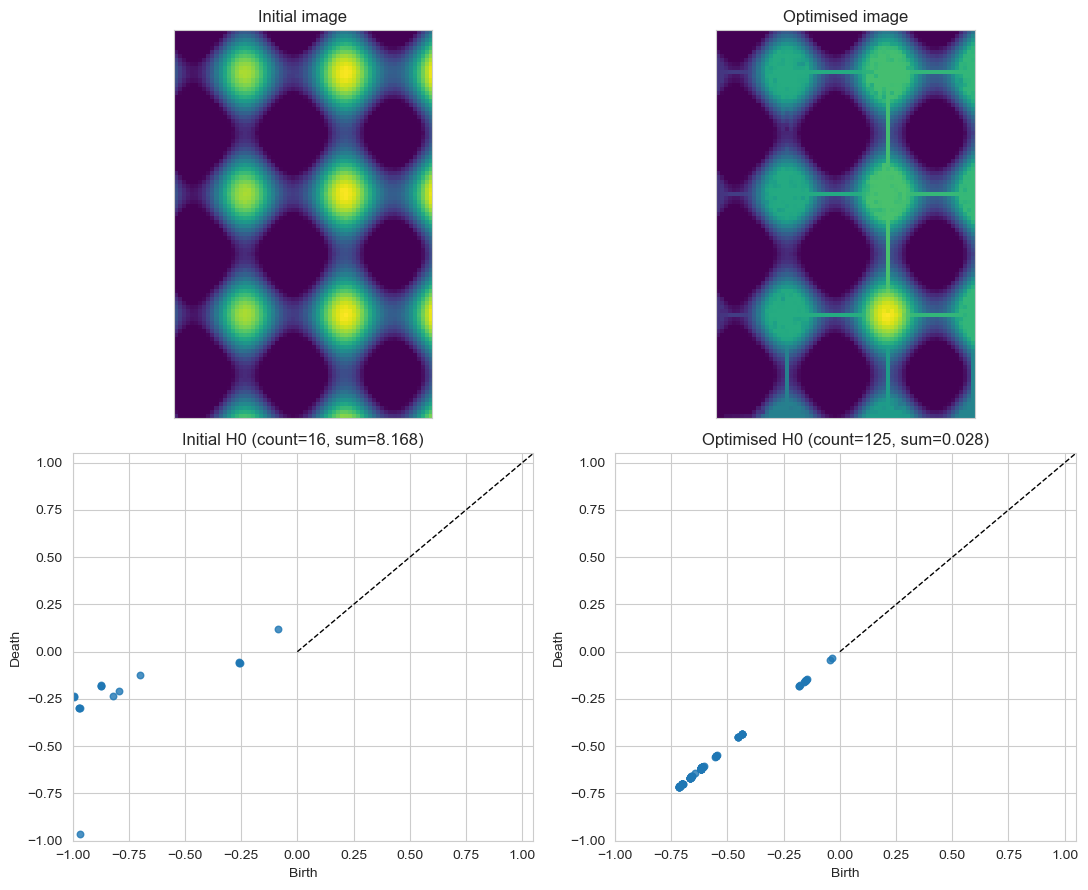

In [223]:
# Final comparison.
fig, axs = plt.subplots(2, 2, figsize=(11, 9))

axs[0, 0].imshow(X0, cmap='viridis', vmin=0.0, vmax=1.0)
axs[0, 0].set_title('Initial image')
axs[0, 1].imshow(X_opt, cmap='viridis', vmin=0.0, vmax=1.0)
axs[0, 1].set_title('Optimised image')
for ax in axs[0]:
    ax.set_xticks([])
    ax.set_yticks([])

def h0_diag_superlevel(img):
    ph = cripser.compute_ph(-img, maxdim=0, filtration='V')
    return ph[(ph[:, 0] == 0) & np.isfinite(ph[:, 2]), 1:3]

d0 = h0_diag_superlevel(X0.numpy())
d1 = h0_diag_superlevel(X_opt)

def draw_diag(ax, d, title):
    max_val = 1.0
    if d.size > 0:
        max_val = max(max_val, float(np.nanmax(d)))
    max_val *= 1.05
    ax.plot([0, max_val], [0, max_val], 'k--', linewidth=1)
    if d.size > 0:
        ax.scatter(d[:, 0], d[:, 1], s=22, alpha=0.8)
    ax.set_xlim(-1, max_val)
    ax.set_ylim(-1, max_val)
    ax.set_xlabel('Birth')
    ax.set_ylabel('Death')
    ax.set_title(title)
    ax.grid(True)

draw_diag(axs[1, 0], d0, f'Initial H0 (count={d0.shape[0]}, sum={np.sum(d0[:,1]-d0[:,0]):.3f})')
draw_diag(axs[1, 1], d1, f'Optimised H0 (count={d1.shape[0]}, sum={np.sum(d1[:,1]-d1[:,0]):.3f})')

plt.tight_layout()
plt.show()

## PH Regularised MDS

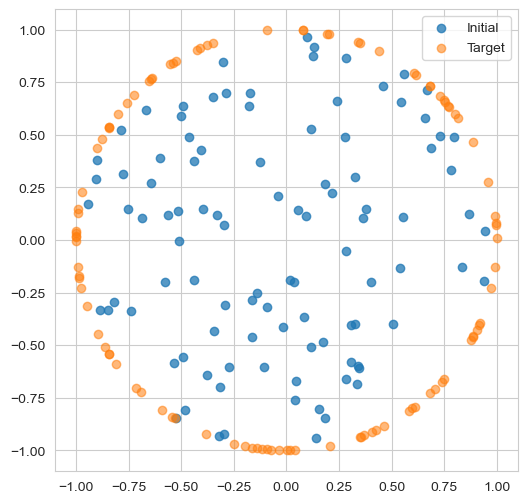

In [240]:
#### Settings.
n_points = 100
noise = 0.0
ambient_dim = 2
max_homology_dim = 1
ph_dim = 1
p, q = 2, 2
seed = 42
rips_max_edge_length = 2.0

# target_PH_source in ["pointcloud", "manual"]
# target_PH is only used when target_PH_source == "manual".
# target_PH = [[birth, death], ...]
target_PH_source = "pointcloud"
target_PH = [[0.8, 1.8]]

# Create the initial point cloud; this will be optimised.
X = sample_from_disk(n=n_points, r=0.0, R=1.0, seed=seed)
X = X + np.random.normal(scale=noise, size=X.shape)

Y = sample_from_sphere(n=n_points, d=ambient_dim - 1, seed=seed + 1)

plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], label='Initial', alpha=0.75)
plt.scatter(Y[:, 0], Y[:, 1], label='Target', alpha=0.55)
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.legend()
plt.show()

X = torch.as_tensor(X, dtype=torch.float32, device=device)
X = torch.nn.Parameter(X.clone(), requires_grad=True)
Y = torch.as_tensor(Y, dtype=torch.float32, device=device)

cdist_target = torch.cdist(Y, Y, p=2)

if target_PH_source == "pointcloud":
    ph_target = compute_ph_rips(
        Y,
        maxdim=max_homology_dim,
        p=2,
        max_edge_length=rips_max_edge_length,
        location="yes",
    )
    target_h1 = finite_diagram(ph_target, ph_dim).detach()
else:
    target_h1 = torch.tensor(target_PH, dtype=torch.float32, device=device)


  0%|          | 0/300 [00:00<?, ?it/s]

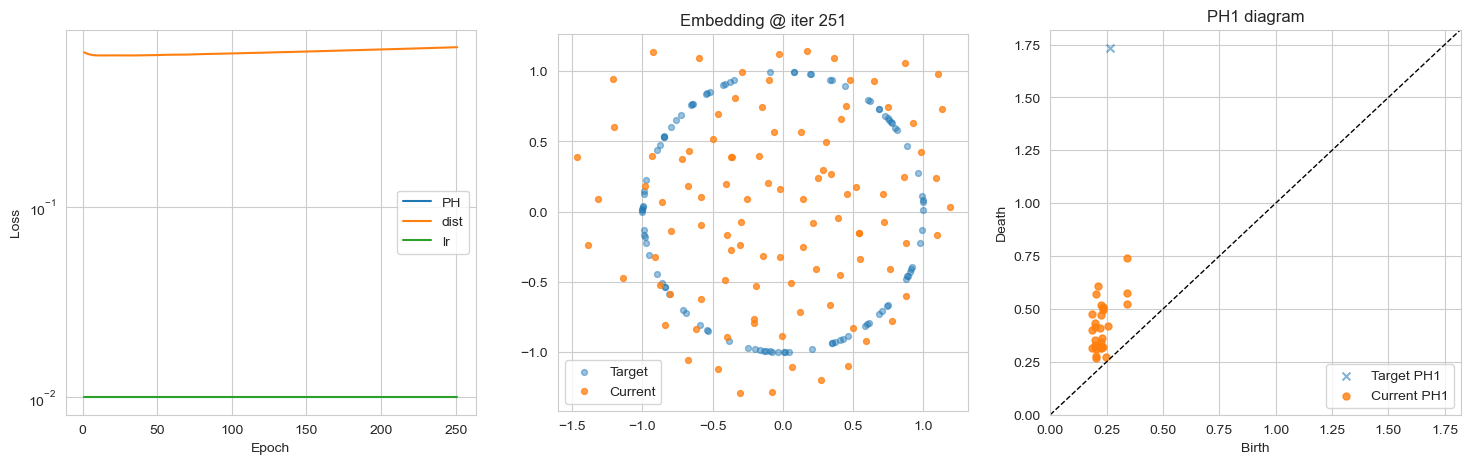

In [241]:
## Optimise embedding.

n_iterations = 300
disp_interval = 50

# Distortion and PH-loss weights.
lambda_dist = 0.2
lambda_PH = 0.05

# ph_loss_mode in ["wasserstein", "total_h1_life_max", "total_h1_life_min"]
ph_loss_mode = "total_h1_life_max"

lr = 1e-2
opt = optim.Adam([X], lr=lr, weight_decay=0)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, 'min')

loss_dist = torch.zeros(1, device=device)
loss_ph = torch.zeros(1, device=device)
progress = tqdm(range(n_iterations))

# Live plots: loss (left), point cloud (middle), and PH diagram (right).
fig_live, axs_live = plt.subplots(1, 3, figsize=(18, 5))
disp_live = display(fig_live, display_id=True)
losses = {"epoch": [], "PH": [], "dist": [], "lr": []}

Y_np = Y.detach().cpu().numpy()

for i in progress:
    ph_source = compute_ph_rips(
        X,
        maxdim=max_homology_dim,
        p=2,
        max_edge_length=rips_max_edge_length,
        location="yes",
    )
    source_h1 = finite_diagram(ph_source, ph_dim)
    h1_life = cripser.finite_lifetimes(ph_source, dim=ph_dim).clamp_min(0.0)

    if lambda_PH > 0:
        if ph_loss_mode == "wasserstein":
            loss_ph = cripser.wasserstein_distance(source_h1, target_h1, p=p, q=q)
        elif ph_loss_mode == "total_h1_life_max":
            loss_ph = -(h1_life.sum() if h1_life.numel() > 0 else X.new_tensor(0.0))
        elif ph_loss_mode == "total_h1_life_min":
            loss_ph = h1_life.sum() if h1_life.numel() > 0 else X.new_tensor(0.0)
        else:
            raise ValueError(f"Unknown ph_loss_mode: {ph_loss_mode}")

    if lambda_dist > 0:
        loss_dist = ((torch.cdist(X, Y, p=2) - cdist_target) ** 2).mean()

    loss = lambda_PH * loss_ph + lambda_dist * loss_dist
    opt.zero_grad()
    loss.backward()
    opt.step()
    scheduler.step(loss)

    losses["PH"].append(float(loss_ph.detach().cpu()))
    losses["dist"].append(float(loss_dist.detach().cpu()))
    losses["lr"].append(scheduler.get_last_lr()[0])
    losses["epoch"].append(i + 1)

    if i % disp_interval == 0:
        # Left: loss curves.
        plot_loss(losses, ax=axs_live[0])

        # Middle: current embedding vs target.
        axs_live[1].clear()
        X_np = X.detach().cpu().numpy()
        axs_live[1].scatter(Y_np[:, 0], Y_np[:, 1], s=18, alpha=0.45, label='Target')
        axs_live[1].scatter(X_np[:, 0], X_np[:, 1], s=18, alpha=0.75, label='Current')
        axs_live[1].set_title(f'Embedding @ iter {i + 1}')
        axs_live[1].set_aspect('equal', adjustable='box')
        axs_live[1].grid(True)
        axs_live[1].legend(loc='best')

        # Right: current PH_1 diagram vs target PH_1.
        axs_live[2].clear()
        current_dgm = source_h1.detach().cpu().numpy()
        target_dgm = target_h1.detach().cpu().numpy()

        max_val = 1.0
        if current_dgm.size > 0:
            max_val = max(max_val, float(np.nanmax(current_dgm)))
        if target_dgm.size > 0:
            max_val = max(max_val, float(np.nanmax(target_dgm)))
        max_val *= 1.05

        axs_live[2].plot([0, max_val], [0, max_val], 'k--', linewidth=1)
        if target_dgm.size > 0:
            axs_live[2].scatter(
                target_dgm[:, 0], target_dgm[:, 1],
                s=32, alpha=0.55, marker='x', label='Target PH1'
            )
        if current_dgm.size > 0:
            axs_live[2].scatter(
                current_dgm[:, 0], current_dgm[:, 1],
                s=25, alpha=0.8, label='Current PH1'
            )
        axs_live[2].set_xlim(0, max_val)
        axs_live[2].set_ylim(0, max_val)
        axs_live[2].set_title('PH1 diagram')
        axs_live[2].set_xlabel('Birth')
        axs_live[2].set_ylabel('Death')
        axs_live[2].grid(True)
        axs_live[2].legend(loc='best')

        disp_live.update(fig_live)

    progress.set_postfix(loss=f'{loss.item():.08f}')

plt.close('all')


## PH regularised graph embedding

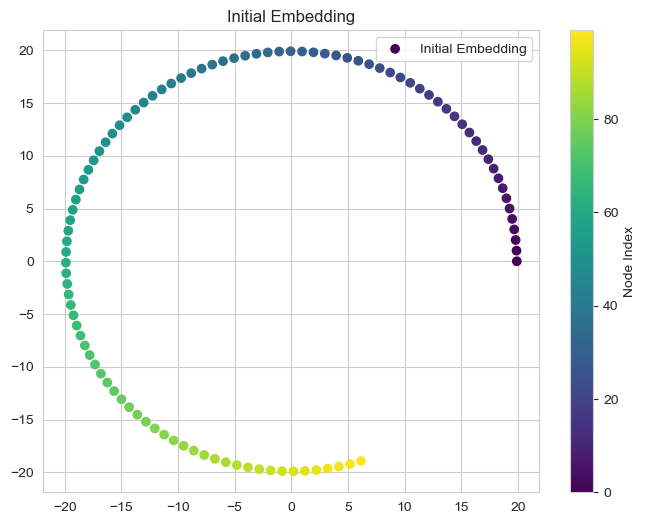

In [246]:

## Initialise embedding.
## Create a graph using NetworkX.
n_points = 100
seed = 42
p, q = 2, 2
# Use full VR here; with a small max_edge_length (e.g. 3.0) this example has no H1 pairs,
# making Wasserstein H1 loss effectively constant.
rips_max_edge_length = None

G = nx.cycle_graph(n_points)
G.remove_edge(0, n_points - 1)  # missing edge
src = torch.tensor([i for i, j in G.edges], dtype=torch.long, device=device)
dst = torch.tensor([j for i, j in G.edges], dtype=torch.long, device=device)
weights = torch.ones(len(G.edges), dtype=torch.float32, device=device)

initialisation = "incomplete_circle"  # ["incomplete_circle", "random", "torocoid"]

def initialise_embedding(initialisation, n_points, seed, G):
    if initialisation == "random":
        # Random initialisation within a disc.
        X = sample_from_disk(n=n_points, r=0.0, R=1.0, seed=seed)
    elif initialisation == "incomplete_circle":
        # Synthetic initialisation (incomplete circle).
        t = np.linspace(0, 2 * np.pi, n_points)
        s = 0.8
        r = n_points / (s * 2 * np.pi)
        X = r * np.vstack([np.cos(s * t), np.sin(s * t)]).T
    elif initialisation == "torocoid":
        # Synthetic initialisation (torocoid).
        t = np.linspace(0, 4 * np.pi, n_points) + np.pi / 2 + eps  # break symmetry
        a = 0.3
        X = np.vstack([a * t - np.cos(t), a - np.sin(t)]).T
        r = 1 / np.sqrt(((X[[i for i, j in G.edges]] - X[[j for i, j in G.edges]]) ** 2).sum(1)).mean()
        X = r * X
    else:
        raise ValueError(f"Unknown initialisation method: {initialisation}")
    return X

# Initialise embedding.
X = initialise_embedding(initialisation, n_points, seed, G)

# Plot the initial embedding.
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=range(len(X)), cmap='viridis', label='Initial Embedding')
plt.colorbar(label='Node Index')
plt.title('Initial Embedding')
plt.legend()
plt.show()

# Convert to a tensor and set it as an optimisation parameter.
X = torch.as_tensor(X, dtype=torch.float32, device=device)
X = torch.nn.Parameter(X.clone(), requires_grad=True)


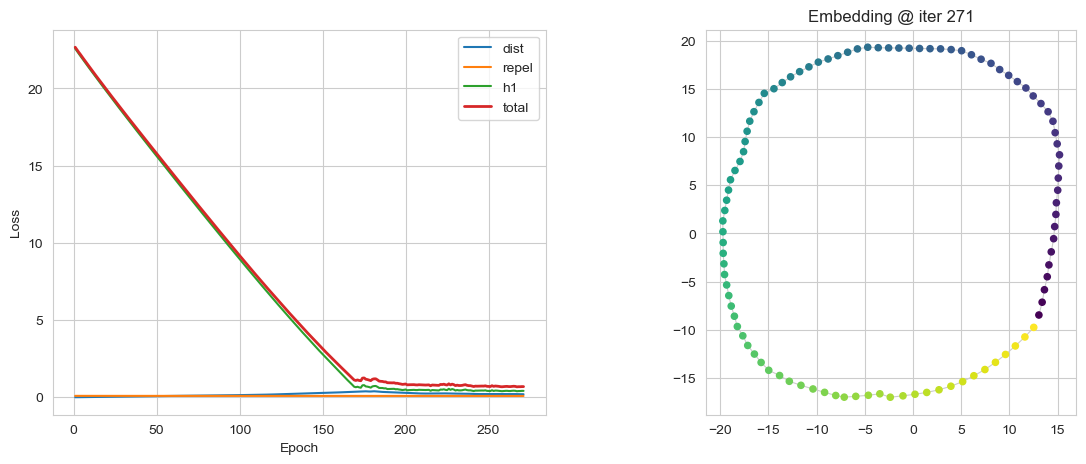

  0%|          | 0/300 [00:00<?, ?it/s]

In [247]:

## Optimise embedding.
lr = 5e-2
opt = optim.Adam([X], lr=lr, weight_decay=0)
lambda_dist = 1
lambda_repel = 1
lambda_h1 = 1
batch_ratio = 1
disp_interval = 30

loss_repel = torch.zeros(1, device=device)
loss_h1 = torch.zeros(1, device=device)

h1_loss_type = "wasserstein"  # ["total_h1_life_max", "total_h1_life_min", "wasserstein"]

n_iterations = 300

# Target PH_1 diagram (single dominant loop).
PH = [[1.0, n_points / np.pi]]
target_h1 = torch.tensor(PH, dtype=torch.float32, device=device)

# Live plots: losses (left) + embedding (right)
fig_live, axs_live = plt.subplots(1, 2, figsize=(14, 5))
disp_live = display(fig_live, display_id=True)
losses = {"epoch": [], "dist": [], "repel": [], "h1": [], "h1_count": [], "total": []}

progress = tqdm(range(n_iterations))
for i in progress:
    batch_edge = torch.randperm(int(batch_ratio * len(G.edges)), device=device)
    batch_vertex = torch.randperm(int(batch_ratio * len(G.nodes)), device=device)

    # Distance term.
    loss_dist = ((((X[src[batch_edge]] - X[dst[batch_edge]]) ** 2).sum(dim=1) - weights[batch_edge]) ** 2).mean()

    if lambda_repel > 0:
        # Exclude diagonal terms to avoid a large constant from 1/eps.
        dmat = torch.cdist(X[batch_vertex], X[batch_vertex], p=2)
        non_diag = ~torch.eye(dmat.shape[0], dtype=torch.bool, device=dmat.device)
        loss_repel = (1.0 / (dmat[non_diag] + eps)).mean()

    ph_source = compute_ph_rips(
        X,
        maxdim=1,
        p=2,
        max_edge_length=rips_max_edge_length,
        location="yes",
    )
    source_h1 = finite_diagram(ph_source, 1)
    h1_life = cripser.finite_lifetimes(ph_source, dim=1).clamp_min(0.0)

    if lambda_h1 > 0:
        if h1_loss_type == "total_h1_life_min":
            loss_h1 = h1_life.sum() if h1_life.numel() > 0 else X.new_tensor(0.0)
        elif h1_loss_type == "total_h1_life_max":
            loss_h1 = -(h1_life.sum() if h1_life.numel() > 0 else X.new_tensor(0.0))
        elif h1_loss_type == "wasserstein":
            loss_h1 = cripser.wasserstein_distance(source_h1, target_h1, p=p, q=q)
        else:
            if h1_life.numel() == 0:
                loss_h1 = X.new_tensor(100.0 ** 2)
            else:
                loss_h1 = (h1_life.max() - 100.0) ** 2 + (h1_life ** 2).mean()
    loss = lambda_dist * loss_dist + lambda_repel * loss_repel + lambda_h1 * loss_h1
    opt.zero_grad()
    loss.backward()
    opt.step()

    losses["epoch"].append(i + 1)
    losses["dist"].append(float(loss_dist.detach().cpu()))
    losses["repel"].append(float(loss_repel.detach().cpu()))
    losses["h1"].append(float(loss_h1.detach().cpu()))
    losses["h1_count"].append(int(source_h1.shape[0]))
    losses["total"].append(float(loss.detach().cpu()))

    if i % disp_interval == 0:
        # Left: losses
        axs_live[0].clear()
        axs_live[0].plot(losses["epoch"], losses["dist"], label="dist")
        axs_live[0].plot(losses["epoch"], losses["repel"], label="repel")
        axs_live[0].plot(losses["epoch"], losses["h1"], label="h1")
        axs_live[0].plot(losses["epoch"], losses["total"], label="total", linewidth=2)
        axs_live[0].set_xlabel("Epoch")
        axs_live[0].set_ylabel("Loss")
        axs_live[0].grid(True)
        axs_live[0].legend()

        # Right: current embedding with graph edges
        axs_live[1].clear()
        X_np = X.detach().cpu().numpy()
        for u, v in G.edges:
            axs_live[1].plot([X_np[u, 0], X_np[v, 0]], [X_np[u, 1], X_np[v, 1]], color="0.8", linewidth=0.8, zorder=1)
        axs_live[1].scatter(X_np[:, 0], X_np[:, 1], c=np.arange(len(X_np)), cmap="viridis", s=20, zorder=2)
        axs_live[1].set_title(f"Embedding @ iter {i + 1}")
        axs_live[1].set_aspect("equal", adjustable="box")
        axs_live[1].grid(True)

        disp_live.update(fig_live)

    progress.set_postfix(loss=f'{loss.item():.08f}', h1=f'{loss_h1.item():.08f}', h1_count=int(source_h1.shape[0]))

plt.close('all')
